In [1]:
import sys
!{sys.executable} -m pip install undetected-chromedriver kiwipiepy nltk pandas openpyxl pyperclip gensim wordcloud bertopic seaborn undetected-chromedriver sentence-transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [10]:
!pip install bertopic
!pip install --upgrade joblib  # 호환성 문제 방지

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/671.7 kB ? eta -:--:--
   ---------------------------------------- 671.7/671.7 kB 8.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 1.3/113.8 MB 7.6 MB/s eta 0:00:15
   - -------------------------------------- 2.9/113.8 MB 7.0 MB/s eta 0:00:16
   - -------------------------------------- 4.5/113.8 MB 7.5 MB/s eta 0:00:15
   -- ------------------------------------- 6.0/113.8 MB 7.5 MB/s eta 0:00:15
   -- ------------------------------------- 7.6/113.8 MB 7.6 MB/s eta 0:00:15
   --- ------------------------------------ 9.2/113.8 MB 7.6 MB/s eta 0:00:14
   --- ------------------------------------ 10.7/113.8 MB 7.6 MB/s eta 0:00:14
   ---- ----------------------------------- 12.1/113.8 MB 7.5 MB/s eta 0:00:14
   ---- ----------------------------------- 13.1/113.8 MB 7.2 MB/s eta 0:00:14


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
effdet 0.4.1 requires torchvision, which is not installed.
timm 1.0.22 requires torchvision, which is not installed.
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


# 차트 리스트 크롤링

In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import random

# ==========================================
# 1. 설정
# ==========================================
START_YEAR = 1996
END_YEAR = 2025

# ==========================================
# 2. 드라이버 설정
# ==========================================
def get_driver():
    chrome_options = Options()
    chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--log-level=3") # 불필요한 로그 숨김
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# ==========================================
# 3. 핵심: 데이터 추출 함수 (불량 제거 & 강제 추출)
# ==========================================
def scrape_list_info(driver, year, month):
    collected_data = []
    
    # --- [1페이지] ---
    print(f"     📄 1페이지 읽는 중...", end=" ")
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.d_song_list tbody tr")))
        
        # [팁] 가끔 데이터가 로딩 덜 될 수 있으니 살짝 스크롤
        driver.execute_script("window.scrollTo(0, 500);")
        time.sleep(0.5)
        
        rows = driver.find_elements(By.CSS_SELECTOR, "div.d_song_list tbody > tr")
        first_song_id = None
        
        count_valid = 0
        for i, row in enumerate(rows):
            if "데이터가 없습니다" in row.text: 
                print("(데이터 없음)")
                return []
            try:
                # [핵심 1] textContent로 숨겨진 텍스트까지 강제 추출
                title = row.find_element(By.CLASS_NAME, "rank01").get_attribute("textContent").strip()
                
                # [핵심 2] 제목이 비어있으면 '유령 데이터'이므로 즉시 버림
                if not title: continue
                
                # 가수 정보도 강제로 긁기
                artist = row.find_element(By.CLASS_NAME, "rank02").get_attribute("textContent").strip()
                try: album = row.find_element(By.CLASS_NAME, "rank03").get_attribute("textContent").strip()
                except: album = ""
                
                song_id = row.find_element(By.NAME, "input_check").get_attribute('value')
                if first_song_id is None: first_song_id = song_id # 페이지 넘김 확인용
                
                # 순위 계산
                try:
                    rank = int(row.find_element(By.CLASS_NAME, "rank").text)
                except: rank = len(collected_data) + 1

                collected_data.append({
                    'Year': year, 'Month': month, 'Rank': rank, 
                    'Title': title, 'Artist': artist, 'Album': album, 'Song_ID': song_id
                })
                count_valid += 1
            except: continue
        print(f"-> {count_valid}곡 완료")

    except Exception as e:
        print(f"-> 에러: {e}")
        return []

    # 100곡 다 찼으면 종료
    if len(collected_data) >= 100: 
        return collected_data

    # --- [2페이지] ---
    print(f"     📄 2페이지 이동...", end=" ")
    try:
        page2_btn = driver.find_element(By.XPATH, "//a[contains(@href, 'movePage(2)')]")
        driver.execute_script("arguments[0].click();", page2_btn)
        
        # [핵심 3] 화면이 바뀔 때까지 확실히 대기 (첫 곡 ID가 바뀔 때까지)
        try:
            WebDriverWait(driver, 5).until(
                lambda d: d.find_element(By.CSS_SELECTOR, "div.d_song_list tbody > tr input[name='input_check']").get_attribute('value') != first_song_id
            )
        except: pass
        
        driver.execute_script("window.scrollTo(0, 500);") # 스크롤
        time.sleep(0.5)

        rows_p2 = driver.find_elements(By.CSS_SELECTOR, "div.d_song_list tbody > tr")
        count_valid_p2 = 0
        
        for i, row in enumerate(rows_p2):
            try:
                title = row.find_element(By.CLASS_NAME, "rank01").get_attribute("textContent").strip()
                if not title: continue # 불량 제거
                
                artist = row.find_element(By.CLASS_NAME, "rank02").get_attribute("textContent").strip()
                try: album = row.find_element(By.CLASS_NAME, "rank03").get_attribute("textContent").strip()
                except: album = ""
                
                song_id = row.find_element(By.NAME, "input_check").get_attribute('value')
                
                try:
                    rank = int(row.find_element(By.CLASS_NAME, "rank").text)
                except: rank = 50 + count_valid_p2 + 1

                collected_data.append({
                    'Year': year, 'Month': month, 'Rank': rank, 
                    'Title': title, 'Artist': artist, 'Album': album, 'Song_ID': song_id
                })
                count_valid_p2 += 1
            except: continue
        print(f"-> {count_valid_p2}곡 추가")
        
    except:
        print("(2페이지 없음)")
        pass

    # [중복 제거] Song_ID 기준으로 깔끔하게 정리
    unique_dict = {v['Song_ID']: v for v in collected_data}
    final_list = list(unique_dict.values())
    final_list.sort(key=lambda x: x['Rank'])
    
    print(f"     ✅ 정제 후 최종 {len(final_list)}곡 확보")
    return final_list

# ==========================================
# 4. 메인 실행
# ==========================================
def main():
    driver = get_driver()
    wait = WebDriverWait(driver, 10)
    
    # 메인 경유
    try: driver.get("https://www.melon.com"); time.sleep(2)
    except: pass
    
    print(f"🚀 [Melon Clean Scraper] {START_YEAR} ~ {END_YEAR}")

    for year in range(START_YEAR, END_YEAR + 1):
        print(f"\n⭐️ [YEAR: {year}]")
        year_data = []

        for month in range(1, 13):
            target_genre = "국내종합"
            if year < 2004: target_genre = "국내종합"
            elif year == 2004: target_genre = "국내종합" if month <= 10 else "가요"
            elif year < 2017: target_genre = "가요"
            else: target_genre = "국내종합"
            
            print(f"\n=== {year}년 {month}월 [{target_genre}] ===")
            
            for attempt in range(3):
                try:
                    driver.get("https://www.melon.com/chart/search/index.htm")
                    time.sleep(random.uniform(1.5, 2.0))

                    # 1. 탭 클릭
                    try:
                        tab = driver.find_element(By.XPATH, "//a[contains(text(), '월간차트')]")
                        driver.execute_script("arguments[0].click();", tab)
                    except: pass
                    time.sleep(0.5)

                    # 2. 검색 조건
                    decade = (year // 10) * 10
                    
                    # 연대
                    xpath_decade = f"//label[contains(text(), '{decade}년대')]"
                    btn_decade = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_decade)))
                    driver.execute_script("arguments[0].click();", btn_decade)
                    
                    # 연도
                    xpath_year = f"//label[contains(text(), '{year}년')]"
                    btn_year = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_year)))
                    driver.execute_script("arguments[0].click();", btn_year)
                    time.sleep(0.2)
                    
                    # 월
                    xpath_month = f"//label[contains(text(), '{month:02d}월')]"
                    driver.execute_script("arguments[0].click();", driver.find_element(By.XPATH, xpath_month))
                    time.sleep(0.2)
                    
                    # 장르
                    try:
                        xpath_genre = f"//label[contains(text(), '{target_genre}')]"
                        driver.execute_script("arguments[0].click();", driver.find_element(By.XPATH, xpath_genre))
                    except: pass
                    time.sleep(0.2)

                    # 검색
                    driver.execute_script("arguments[0].click();", driver.find_element(By.CLASS_NAME, "btn_b26"))
                    time.sleep(1.2)

                    # 데이터 수집 (정제된 함수 사용)
                    data = scrape_list_info(driver, year, month)
                    
                    if data:
                        year_data.extend(data)
                        break
                    else:
                        print(f"     ⚠️ 데이터 0건. 재시도 {attempt+1}")
                        time.sleep(2)
                        
                except Exception as e:
                    print(f"     ❌ 에러: {e}")
                    if attempt == 2: driver.refresh(); time.sleep(3)
                    time.sleep(1)

        if year_data:
            df = pd.DataFrame(year_data)
            df['Lyrics'] = "" 
            file_name = f"Melon_Chart_{year}.xlsx"
            df.to_excel(file_name, index=False)
            print(f"💾 {year}년 저장 완료! (총 {len(df)}곡)")
        else:
            print(f"⚠️ {year}년 데이터 없음")

    print("\n🎉 전체 완료!")

if __name__ == "__main__":
    main()

🚀 [Melon Clean Scraper] 1996 ~ 2025

⭐️ [YEAR: 1996]

=== 1996년 1월 [국내종합] ===
     📄 1페이지 읽는 중... -> 62곡 완료
-> 62곡 추가페이지 이동... 
     ✅ 정제 후 최종 62곡 확보

=== 1996년 2월 [국내종합] ===
     📄 1페이지 읽는 중... -> 57곡 완료
-> 57곡 추가페이지 이동... 
     ✅ 정제 후 최종 57곡 확보

=== 1996년 3월 [국내종합] ===
     📄 1페이지 읽는 중... -> 56곡 완료
-> 56곡 추가페이지 이동... 
     ✅ 정제 후 최종 56곡 확보

=== 1996년 4월 [국내종합] ===
     📄 1페이지 읽는 중... -> 58곡 완료
-> 58곡 추가페이지 이동... 
     ✅ 정제 후 최종 58곡 확보

=== 1996년 5월 [국내종합] ===
     📄 1페이지 읽는 중... -> 58곡 완료
-> 58곡 추가페이지 이동... 
     ✅ 정제 후 최종 58곡 확보

=== 1996년 6월 [국내종합] ===
     📄 1페이지 읽는 중... -> 59곡 완료
-> 59곡 추가페이지 이동... 
     ✅ 정제 후 최종 59곡 확보

=== 1996년 7월 [국내종합] ===
     📄 1페이지 읽는 중... -> 61곡 완료
-> 61곡 추가페이지 이동... 
     ✅ 정제 후 최종 61곡 확보

=== 1996년 8월 [국내종합] ===
     📄 1페이지 읽는 중... -> 59곡 완료
-> 59곡 추가페이지 이동... 
     ✅ 정제 후 최종 59곡 확보

=== 1996년 9월 [국내종합] ===
     📄 1페이지 읽는 중... -> 62곡 완료
-> 62곡 추가페이지 이동... 
     ✅ 정제 후 최종 62곡 확보

=== 1996년 10월 [국내종합] ===
     📄 1페이지 읽는 중... -> 62곡 완료
-> 62곡 추가페이지 이동...

# 가사 크롤링

In [34]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import glob
import os

# ==========================================
# 1. 설정
# ==========================================
def get_driver():
    chrome_options = Options()
    # CMD 크롬 연결
    chrome_options.add_experimental_option("debuggerAddress", "127.0.0.1:9222")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# ==========================================
# 2. 핵심: 브라우저에서 쿠키(열쇠) 훔쳐오기
# ==========================================
def get_session_from_chrome(driver):
    session = requests.Session()
    
    # 1. 헤더 복사 (사람인 척)
    headers = {
        "User-Agent": driver.execute_script("return navigator.userAgent;"),
        "Referer": "https://m2.melon.com/"
    }
    session.headers.update(headers)
    
    # 2. 쿠키 복사 (로그인 정보 탈취)
    # 멜론 메인에서 쿠키를 긁어와야 함
    if "melon.com" not in driver.current_url:
        driver.get("https://m2.melon.com")
        time.sleep(2)
        
    cookies = driver.get_cookies()
    for cookie in cookies:
        session.cookies.set(cookie['name'], cookie['value'])
        
    return session

# ==========================================
# 3. 가사 수집 (모바일 뒷문 이용)
# ==========================================
def get_lyrics_mobile(session, song_id):
    # PC 페이지 말고 가벼운 모바일 페이지 공격
    url = f"https://m2.melon.com/song/lyrics.htm?songId={song_id}"
    
    try:
        response = session.get(url, timeout=10)
        
        # 차단 확인
        if "captcha" in response.url or response.status_code != 200:
            return "BLOCKED"
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # 모바일 페이지 가사 태그 (.lyric)
        lyric_div = soup.find('div', {'class': 'lyric'})
        
        if lyric_div:
            # <br> -> 줄바꿈
            for br in lyric_div.find_all("br"):
                br.replace_with("\n")
            
            # 불필요한 공백 제거
            lyrics = lyric_div.get_text().strip()
            
            if not lyrics: return "가사없음"
            return lyrics
        
        # 가사 태그가 없으면 -> 19금인지 확인
        if "19세" in response.text or "성인" in response.text:
            return "19금(확인필요)"
            
        return "가사없음"

    except Exception as e:
        return "ERROR"

# ==========================================
# 4. 메인 실행
# ==========================================
def main():
    file_list = sorted(glob.glob("Melon_Chart_*.xlsx"))
    if not file_list:
        print("❌ 엑셀 파일이 없습니다.")
        return

    # 1. CMD 크롬 연결
    driver = get_driver()
    if not driver: return
    
    print("🚀 [쿠키 탈취 모드] 가사 수집 시작")
    print("👉 크롬은 로그인된 상태로 그냥 켜두세요 (건드리지 않음)")
    
    # 2. 세션(열쇠) 생성
    session = get_session_from_chrome(driver)
    print("🔑 로그인 정보(쿠키) 복사 완료! 이제 파이썬이 직접 수집합니다.")

    for file_path in file_list:
        print(f"\n📂 파일 처리 중: {file_path}")
        
        try:
            df = pd.read_excel(file_path)
            if 'Lyrics' not in df.columns: df['Lyrics'] = ""
            
            # 수집 대상 (가사 없는 것만)
            target_mask = (df['Lyrics'].isna() | (df['Lyrics'] == "") | (df['Lyrics'] == "ERROR") | (df['Lyrics'] == "접근불가")) & (df['Song_ID'].notna())
            target_indices = df[target_mask].index
            
            total = len(target_indices)
            if total == 0:
                print("   ✅ 완료된 파일.")
                continue
                
            print(f"   👉 남은 곡: {total}개")
            
            count = 0
            for idx in target_indices:
                song_id = int(df.loc[idx, 'Song_ID'])
                title = df.loc[idx, 'Title']
                
                # 수집 (requests 사용 -> 브라우저 이동 X -> 접근불가 안 뜸)
                lyrics = get_lyrics_mobile(session, song_id)
                
                # 차단 감지 시
                if lyrics == "BLOCKED":
                    print(f"\n   🚨 [잠깐!] 보안 문자가 떴거나 세션이 만료됨.")
                    print("   👉 크롬 창을 띄워서 멜론 새로고침 한번 해주세요 (로그인 유지 확인)")
                    input("   👌 해결했으면 Enter >> ")
                    # 세션 갱신
                    session = get_session_from_chrome(driver)
                    lyrics = get_lyrics_mobile(session, song_id)
                
                df.loc[idx, 'Lyrics'] = lyrics
                
                # 출력
                display = lyrics[:10].replace('\n', ' ') + "..." if len(lyrics) > 5 else lyrics
                print(f"   [{count+1}/{total}] {title} : {display}")
                
                count += 1
                
                # 속도 조절 (너무 빠르면 또 막히니 살짝 쉼)
                time.sleep(random.uniform(0.5, 1.0))
                
                if count % 50 == 0:
                    df.to_excel(file_path, index=False)
                    print("   💾 중간 저장...")
            
            df.to_excel(file_path, index=False)
            print(f"   🎉 {file_path} 완료!")

        except Exception as e:
            print(f"   ❌ 에러: {e}")
            if 'df' in locals(): df.to_excel(file_path, index=False)

    print("\n🏁 진짜 끝! 고생하셨습니다.")

if __name__ == "__main__":
    main()

🚀 [쿠키 탈취 모드] 가사 수집 시작
👉 크롬은 로그인된 상태로 그냥 켜두세요 (건드리지 않음)
🔑 로그인 정보(쿠키) 복사 완료! 이제 파이썬이 직접 수집합니다.

📂 파일 처리 중: Melon_Chart_1996.xlsx
   ✅ 완료된 파일.

📂 파일 처리 중: Melon_Chart_1997.xlsx
   ✅ 완료된 파일.

📂 파일 처리 중: Melon_Chart_1998.xlsx
   ✅ 완료된 파일.

📂 파일 처리 중: Melon_Chart_1999.xlsx
   👉 남은 곡: 749개


C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '내가 원하는 대로
자신 있는 모습 그대로
이제껏 숨겨 왔던 비밀을
네게 모두 말하고 싶어 baby
Funny how all dreams come true
나를 지켜줄거야
아껴왔던 작은 사랑도
Funny how I feel for you
너의 곁에 그려질
꿈결같은 나의 미래도
처음 느낌 그대로
짜릿했던 느낌 그대로
서로가 약속했던 것처럼
같은 생각 갖고 있었지 baby
Funny how all dreams come true
나를 지켜줄꺼야
아껴왔던 작은 사랑도
Funny how I feel for you
너 하나만 사랑해
Come on lover
언제나 둘이 함께
네가 있는 나 행복할 거에요
더 이상 슬픈 노래는
듣지 않을 거예요
내 맘을 알겠죠
Dreams come true
나를 지켜줄거야
아껴왔던 작은 사랑도
Funny how I feel for you
너의 곁에 그려질
꿈결같은 나의 미래도' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/749] Dreams Come True : 내가 원하는 대로 ...
   [2/749] 사랑은 유리같은 것 : 정말 몰랐어요  사...
   [3/749] 1tym : 알겠어 와 와 우리...
   [4/749] Love Story : 행복했던 지난 추억...
   [5/749] 불멸의 사랑 : 나 가진것 없지만 ...
   [6/749] Love Potion No. 9 (영화 '태양은 없다') : Love Porti...
   [7/749] X (The Greatest Love) : 정말 꿈만 같은 운...
   [8/749] 믿음 : 힘든가요 내가 짐이...
   [9/749] 미안해 널 미워해 : 기억 나지 않아 어...
   [10/749] Please Baby Don't Cry : 가사없음
   [11/749] Steal Away (주인공) : 가사없음
   [12/749] 금지된 사랑 : 울지 마  여기에 ...
   [13/749] 사랑하는 날까지 : 사랑은 운명 속에 ...
   [14/749] 미절 (Misery) : 누가 좀 나를 도와...
   [15/749] Poison(Remix) : 가사없음
   [16/749] 사랑일뿐야 (98 Ver.) : 나를 어떻게 생각하...
   [17/749] 빛 (Hope) : 늘 함께 있어  소...
   [18/749] 순정 (純情) : 순정   (純情)워...
   [19/749] 슬픈 독백 : 그렇게 힘겹던 네게...
   [20/749] P.S. I Love You : 우연히 그댈 처음 ...
   [21/749] 루비(淚悲):슬픈 눈물 : 오늘 그녀를 만났어...
   [22/749] 와요와요 : 가사없음
   [23/749] Goodbye : I can see ...
   [24/749] 너 그럴때면... : 울고 싶을 때 너무...
   [25/749] 커플 : 예전보다 지금 네가...
   [26/749] 하나 : 우리 헤어져 살아간...
   [27/749] 작별 : 죄송했어

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '다가오지마 더 이상  
위로될 수 없다는 것을 
모르는 것처럼  
걱정하지마 차라리  
편하기까지 하다니까 
믿고 싶지 않니  
나를 걱정해서 내게 오는 거라면  
이제는 아무렇지도 않아  
니가 후회해서 돌아오는 거라도  
이번에는 내가 싫어  
다가오지마 더 이상  
위로될 수 없다는 것을 
모르는 것처럼  
걱정하지마 차라리 
편하기까지 하다니까  
믿고 싶지 않니 
이제야 간신히 너의 그늘 속에서  
벗어나 담담할 수 있는데  
난 항상 너에게 목을 메고 있다고  
그렇게 착각 한 거니  
다가오지마 더 이상  
위로될 수 없다는 것을 
모르는 것처럼  
걱정하지마 차라리  
편하기까지 하다니까  
믿고 싶지 않니  
다가오지마  
다가오지마 더 이상  
위로될 수 없다는 것을 
모르는 것처럼  
걱정하지마 차라리 
편하기까지 하다니까  
믿고 싶지 않니  
다가오지마 언젠가 다시는  
사랑 할 수 있데도 
No no no no no 
이젠 괜찮아 괜찮아  
그 만큼 그만큼의 고통뿐 
이젠 괜찮아 
다가오지마
걱정하지마
오 이젠 괜찮아' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/770] 부메랑 : 다가오지마 더 이상...
   [2/770] 와 : 사실이 아니길 믿고...
   [3/770] 바꿔 : 모두 제정신이 아니...
   [4/770] 유리의 성 #Story Ⅲ : 모두 지난 일인데 ...
   [5/770] 사랑해 그리고 기억해 : Uh 사랑하는 사람...
   [6/770] 경고 : cuz a part...
   [7/770] 영원 : 너와의 행복했었던 ...
   [8/770] 飛上(비상) : 영혼 그동안 모두 ...
   [9/770] 실연 : 너 떠난후  많이 ...
   [10/770] 슬픈 사랑의 노래 (WITH 이소라) : 너를 스쳐갈 수 있...
   [11/770] 상처(傷處) : 오 니가 없이는 완...
   [12/770] 빈 처(處) : 날 스쳐간 저 바람...
   [13/770] I Believe : 그대 그 약속을 기...
   [14/770] T.T : Good bye 내...
   [15/770] Twilight Zone : Don`t say ...
   [16/770] 너를 보내고 : 구름낀 하늘은 왠지...
   [17/770] Blue Day : 지친 내눈을 깨우며...
   [18/770] 너를 사랑해 : 저 내리는 비를 또...
   [19/770] 비젼 : 아닐거라 말해도 눈...
   [20/770] 19금
								
								
								
								
								날 잊어 1 : 19금(확인필요)...
   [21/770] Good-Bye Day : 김장훈_Good-b...
   [22/770] 서방님 : 잊어요 괜한 걱정마...
   [23/770] 처음 느낌 그대로 : 남 다른 길을 가는...
   [24/770] 너 없는 아침 : 세상에 나와 나보다...
   [25/770] 가니 : 친구들이 말했어 네...
   [26/770] I'm Still Loving You : 햇살같은 그대는 나...
   [27/770] 이해할께 : 너의 손을 잡고

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '잊지 못해 너를 있잖아 
아직도 눈물 흘리며 널 생각해 
늘 참지 못하고 투정 부린 것 미안해 
나만 원한다고 했잖아 
그렇게 웃고 울었던 기억들이 
다른 사랑으로 잊혀져
지워지는게 난 싫어
어떻게든 다시 돌아오길 부탁해 
처음으로 다시 돌아가길 바랄게 
기다릴게 너를 하지만
너무 늦어지면은 안돼
멀어지지마 더 가까이 제발 
모든걸 말할수 없잖아 
마지막 얘길 할테니 좀 들어봐 
많이 사랑하면 할수록
화만 내서 더 미안해
어떻게든 다시 돌아오길 부탁해 
처음으로 다시 돌아가길 바랄게  
기다릴게 너를 하지만
너무 늦어지면은 안돼
멀어지지마 더 가까이 
잊지 말고 다시 돌아오길 부탁해 
헤어지면 가슴 아플거라 생각해 
기다릴게 너를 하지만
너무 늦어지면은 안돼
멀어지지마 더 가까이 제발 
제발 제발' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/759] 제발 : 잊지 못해 너를 있...
   [2/759] 혼잣말 : 가사없음
   [3/759] Story : 내겐 너무 슬픈 사...
   [4/759] 날 닮은 너 : 날 닮은 너를 부족...
   [5/759] Bad : 나 지금 너무 안좋...
   [6/759] 찾길 바래 : 이젠 내 안에 다시...
   [7/759] 그대가 그대를 : 참 많이 모질었었죠...
   [8/759] Passion : It's on an...
   [9/759] 엄마의 일기 : 너그럽게 웃으시는 ...
   [10/759] You Mean Everything To Me : 그대 가슴에 귀를 ...
   [11/759] 각인, 그 후... : 한동안 너를 잊고 ...
   [12/759] 먼 훗날 : 가사없음
   [13/759] 뱀 : 그래 그래 너는 그...
   [14/759] 다짐 : 그때 내가 아니야 ...
   [15/759] 틈 : 난 너의 생각처럼 ...
   [16/759] 감싸 안으며 (Show Me Your Love) : 비 개인 거리를 나...
   [17/759] 눈물없는 이별 : 숨기려 했어 처음엔...
   [18/759] 흐린 가을 하늘에 편지를 써 : 비가 내리면 음 나...
   [19/759] 그런 일은 : 너무나 멀어보여요 ...
   [20/759] 그대 내게 묻는다면 : 커피향기 방안을 채...
   [21/759] 그래! 그렇게! (We Can Do It) : Yo It's ab...
   [22/759] 너 정말? : 요즘 니가 만나는 ...
   [23/759] Delete... : 무심코 그냥 지나는...
   [24/759] 기도 : 혹시 나를 떠나려는...
   [25/759] 울트라맨이야 : we are the...
   [26/759] 너를 위해 : 어쩜 우린 복잡한 ...
   [27/759] Marry Me : Won't you ...
   [28/759] 오버액션 맨 : 수다 떠는 니 친구...
 

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '어두운 불빛 아래 촛불 하나
와인 잔에 담긴 약속 하나
항상 너의 곁에서 널 지켜줄 거야
날 믿어준 너였잖아
나 바라는 건 오직 하나
영원한 행복을 꿈꾸지만
화려하지 않아도 꿈 같지 않아도
너만 있어주면 돼
걱정 마 I Believe
언제나 I Believe
이 순간을 잊지 않을게
내 품에 I Believe
안긴 너의 미소가
영원히 빛을 잃어 가지 않게
Cause your love is so sweet
You are my everything
첫날 밤의 단 꿈에 젖어
하는 말이 아냐
난 변하지 않아
오직 너만 바라볼 거야
You're light of my life
You're the one in my life
내 모든 걸 다 잃는대도
후회하지 않아 오직 너를 위한
변하지 않는 사랑으로
이제 나에게 있어 가장 소중한 건
내가 아닌 당신입니다
말로는 다짐할 수 없지만
당신만을 사랑합니다
때로는 친구처럼 때로는 연인처럼
눈 감는 그 날까지
당신만을 사랑합니다
늘 하나라는 마음으로
흔들리지 않는 믿음으로
아픈 마음도 함께 기쁜 맘도 함께
나눠 가졌으면 해
약속해 I Believe
힘들 때 I Believe
너의 그늘이 되어줄게
내 품에 I Believe
안긴 너의 미소가
영원히 빛을 잃어 가지 않게
Cause your love is so sweet
You are my everything
첫날 밤의 단 꿈에 젖어
하는 말이 아냐
난 변하지 않아
오직 너만 바라볼 거야
You're light of my life
You're the one in my life
내 모든 걸 다 잃는대도
후회하지 않아
오직 너를 위한
변하지 않는 사

   [1/728] 아로하 : 어두운 불빛 아래 ...
   [2/728] Angel Eyes : Jingle bel...
   [3/728] 다시 사랑한다 말할까 : 마치 어제 만난 것...
   [4/728] Starry Night : 오랜뒤에 그냥 그런...
   [5/728] 사랑해도 될까요? : 문이 열리네요 그대...
   [6/728] 벌써 일년 : 처음이라 그래 며칠...
   [7/728] If I Leave (나 가거든) : 쓸쓸한 달빛 아래 ...
   [8/728] 어떤 말로도 : 모자라  내겐 모자...
   [9/728] 남자니까 : 말해 내게 니 걱정...
   [10/728] 미쳐 : 왜 우니 또 왜 그...
   [11/728] 그리고 사랑해 : 지금 돌아선 그대가...
   [12/728] 음악이 뭔데 : 그러니까 서론 본론...
   [13/728] 4월 이야기 (April Story) : 난 오늘 같은 하루...
   [14/728] Last Christmas : 잊어야지 하면서 널...
   [15/728] 길 : 내가 가는 이 길이...
   [16/728] To Be Continued (Yun Suk Theme) : break it d...
   [17/728] 시간이 흐른 뒤 (As Time Goes By) : 마지못해 살아가겠지...
   [18/728] Second Love : 나를 바라보아요 그...
   [19/728] 잘못 : 사랑이라는 말을 접...
   [20/728] 떠난 너 : Why Why 속절...
   [21/728] 사랑하고 싶어 : My Love  M...
   [22/728] 얼씨구 : 아름다운 밤이예요 ...
   [23/728] 잘가요 : 미안해 마요 이제야...
   [24/728] 좋은 사람 (Feat. 김형중) : 오늘은 무슨 일인 ...
   [25/728] 후(後) : 너와 헤어지던 날 ...
   [26/728] The End : 더 말할 것도 부탁...
   [27/728] 

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '점점 넌 멀어지나봐
웃고 있는 날 봐 때론 
며칠씩 편하게 지내
점점 널 잊는 것 같아 먼일처럼
점점 넌 떠나가나봐
하루는 미치고 다음 날이면 
괜찮아졌어
다만 슬픔에 익숙해질 
뿐인걸 점점
어쩌다 또 생각나
너를 그릴 때가 오면 
숨막히게 지쳐
애써 참아낼 수 있겠지
그렇게 널 버려 내 아픔도 점점
점점 넌 멀어지나봐
그게 편해지나봐 너의 얼굴도 
생각이 안나
점점 너를 버릴 것 같아 
나 어느새 점점
어쩌다 또 생각나
너를 그릴 때가 오면 숨막히게 지쳐
애써 참아낼 수 있겠지
그렇게 널 버려 내 아픔도 점점
어쩌다 또 생각나
너를 그릴 때가 오면 
숨막히게 지쳐
애써 참아낼 수 있겠지 
그렇게 널 버려
Long Goodbye No Way 
You Know
이젠 낯선 목소리에 너를 부르는걸
시간이 나를 다 버리고
내 슬픔도 이제 멀어져가 점점' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/754] 점점 : 점점 넌 멀어지나봐...
   [2/754] 아무말도, 아무것도... : 날 위한다 말하진 ...
   [3/754] To My Love (Korean Ver.) : yeah hey H...
   [4/754] 사랑이 올까요 : 많이 사랑했었죠 아...
   [5/754] 백설공주를 사랑한 일곱번째 난장이 : 난 세상에서  가장...
   [6/754] Snowman : When it sn...
   [7/754] Never Ending Story : 손 닿을 수 없는 ...
   [8/754] 사랑해요 : 난 지금 한번도 느...
   [9/754] 편지 : 이 감옥에서 나갈 ...
   [10/754] 달팽이와 해바라기 (Men's Ver.) : 한번만이라도 그대....
   [11/754] 좋은날 : 알고 있나요 내가 ...
   [12/754] 왜 모르니 : 왜 그래 넌 내게 ...
   [13/754] 빚 : 하루하루 변해가는 ...
   [14/754] 인생은 아름다워 (Feat. 박선주) : Turn aroun...
   [15/754] 낙원 (Feat. 이재훈) : 너와 나 단 둘이서...
   [16/754] The Name 名字(명자) : 수천번 수만번 불러...
   [17/754] 너의 결혼식 : Hold up, L...
   [18/754] 팬이야 : 아무렇지 않은 표정...
   [19/754] 내게로 와 : all right ...
   [20/754] 전할 수 없는 이야기 (부제:시티 오브 엔젤) : 나 너를 사랑하나봐...
   [21/754] 아리아리 : 넌 잘난것도 없어 ...
   [22/754] 서른 즈음에 : 또 하루 멀어져간다...
   [23/754] Tatoo (문신) : 사랑밖엔 몰랐었어 ...
   [24/754] The Hero : 또 하루가 시작이 ...
   [25/754] 나비(娜悲)의 겨울 : 시간을 멈출수 있다...
   [26/754] 감기 : 나는 너를 사랑하면...
 

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '한참을 앓고 있죠
사랑한단 뜻이에요 
이 사랑을 깨달은 순간이
제 인생에 젤 힘든 날이었죠 
피할 수 없어 부딪힌 거라고
비킬 수도 없어 받아들인 거라고
하지만 없죠 절 인정할 사람
세상은 제 맘 
미친 장난으로만 보겠죠
바람이 차네요 
제 얘기를 듣나요
저 같은 사랑 해봤던 사람 
혹 있다면은 절 이해할 테죠
단념은 더욱 집착을 만들고
단념은 더욱 나를 아프게 하고 
어떻게 하죠 너무 늦었는데
세상과 저는 
다른 사랑을 하고 있네요 
피할 수 없어 부딪힌 거라고
비킬 수도 없어 받아들인 거라고
하지만 없죠 절 인정할 사람
세상은 제 맘 
미친 장난으로만 보겠죠
담배도 없네요 달도 쓸쓸하네요
저 같은 사랑 시작한 사람 
혹 있다면은 도망쳐요' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/845] 사랑의 時(시) : 한참을 앓고 있죠 ...
   [2/845] She's Mine : 니가 예뻐 보였어 ...
   [3/845] 오래오래 : 난 이별을 몰라서 ...
   [4/845] Double : ready!  외로...
   [5/845] Without You : 그대 향기 없인 숨...
   [6/845] 그리움만 쌓이네 : 다정했던 사람이여 ...
   [7/845] 기도 (Last Pray) : 제발 이러지 말아요...
   [8/845] 난 너에게 (To You) : 사랑 uh 이 세상...
   [9/845] 떠나야만 했나요 : 사랑은 사랑만으로 ...
   [10/845] 미소 : 네게 너무 쉽게 허...
   [11/845] 어쩌다.. : 어쩌다 지나친 거릴...
   [12/845] Can You Tell Me...? : Can you te...
   [13/845] 태양을 피하는 방법 (Gtr.Remix) : 울고 있는 나의 모...
   [14/845] Intro : 19금(확인필요)...
   [15/845] 정상을 향한 독주 2 (Feat. 김범수) : 끝없는 설레임을 넘...
   [16/845] 알아요 : 매일 세상에게 묻곤...
   [17/845] 마지막 돈키호테 : 달빛 물든 그 곳 ...
   [18/845] Ghost School : 어두운 교실속에 난...
   [19/845] Come On : everybody ...
   [20/845] Let Me Dance : Let me dan...
   [21/845] 여전히 : 잊을 수 있을거라 ...
   [22/845] Just One Night : 너를 따라 한번 더...
   [23/845] Part Time Lover (with 휘성) : Call up, r...
   [24/845] Ave Maria In A Minor (드라마 '천국의 계단' 테마곡) : Ave maria,...
   [25/845] 잊었니 : 잊었니 네가 고백했...


C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '아침이면
일어나 창을 열고
상쾌한 공기에
나갈 준비를 하고
한 손엔 뜨거운 커피
한 잔을 든 채
만원버스에
내 몸을 싣고
귀에 꽂은
익숙한 라디오에선
사람들의 세상 사는
즐거운 사연
들으면서 하루가
또 시작되죠
화사하게 빛나는
햇살이 반겨주네요
Oh 어떡하죠
나 그대를 잊고 살아요
Oh 미안해요
나 벌써 괜찮은가봐요
잊지 못할 사랑이라
생각했었는데
잊혀져가네요
어느새

어떻게 간지
모르는 하루
해가 저물때쯤 울리는
친구들의 전화 나오라고
하루 산 얘기
회사 얘기
새로 만난 여자들
데이트 얘기 웃긴 얘기 
지나치는 여자들
바라보기
TV 에 나오는
스포츠 경기에
목숨을 걸고
덤벼들면서 밥값 내기
시간이 가는 줄도
모른 체 떠들다
지쳐서 돌아오니
이런 어느새 새 벽2시
자 자 야겠지
친구들이 오늘했던
얘기 떠올리면
자꾸 웃음이 나와
웃으면서 누워 있으면
잠이 와
Oh 어떡하죠
나 그대를 잊고 살아요
Oh 미안해요
나 벌써 괜찮은가봐요
잊지 못할 사랑이라
생각했었는데
잊혀져가네요
어느새
우리 노랠 들어도
눈물이 나질 않고
네 소식을 들어도
미소가 흘러나오죠
괜찮은 거죠
날 버린 그대
잊어도 되죠
근데 왜 자꾸
이러면 안되는
것만 같은지
미안해 너무나
이렇게 쉽게 잊어서
미안해 내가 했던
말들 못지켜서
하지만 너무 힘들어서
널 더 이상 간직하고
살 수가 없었어
용서해줘
영원히 사랑할 거라고
약속했던 말
돌아선 네 등 뒤에다
맹세했던 말
마지막 날 혼자 울면서
다시는 내가 살아갈
그 날이 끝까지
마음 속에 널
간직할 결심을 한지
얼마 되지도 않았는데
너를 모두 지워버린
내가 너무 미울 거야
그래 정말 내가
약속을 모두 어긴 

   [1/1172] 보통날 : 아침이면 일어나 창...
   [2/1172] 둘이서 (CF - 빙그레 '바나나맛 우유') : 나 나나나 난난나나...
   [3/1172] 겨울일기 : 내 작은 방에 비치...
   [4/1172] Loving You : 나 너 사랑하는 거...
   [5/1172] 헤어지자고 (MBC 슬픈연가 삽입곡) : 나를 떠나가 미안하...
   [6/1172] 사랑의 바보 : 그렇게 말 하지 마...
   [7/1172] 빙고 : Yo How you...
   [8/1172] 자유 : let's get ...
   [9/1172] 불치병 (Feat. Masta Wu) : 난 오늘도 혀를 깨...
   [10/1172] 빙고 (아싸) : 아 싸 Ladies...
   [11/1172] 세월의 흔적 다 버리고 : 헤어졌어도 시간이 ...
   [12/1172] Sad Cafe (With Dynamic Duo) : Out in the...
   [13/1172] I Do : 서로를 느껴가면서 ...
   [14/1172] 잠 못 드는 밤 비는 내리고 : Yeah, The ...
   [15/1172] 귀로 : 화려한 불빛으로 그...
   [16/1172] 쟈크와 래미 이야기 : 수많은 사람중에 항...
   [17/1172] 은영이에게 : 아시겠죠 마지막인걸...
   [18/1172] 그 아픔까지 사랑한거야 : 휴~~벌써 이게 몇...
   [19/1172] 전화번호 : 그대의 이름도 성도...
   [20/1172] 한 남자 : 참 오래됐나 봐 이...
   [21/1172] 날 그만 잊어요 : 난 이제 조금씩 그...
   [22/1172] 사랑이 변하니 : 내 앞에 니가 오늘...
   [23/1172] 천생연분 : 너무 너무  예쁘다...
   [24/1172] 흐린 가을 하늘에 편지를 써 : 비가 내리면 음 나...
   [25/1172] Tonight : 아름다운 그녀가 워...
   [26/1172] Crazy : 넌 모르

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '사는동안 늘 내 하루는
너를 기다리는 일로 시작하고
눈물로 하룰 다 쓰면서
기억을 털어내고
머리는 괜찮다 하는데
가슴은 목이 터져라 울고 있어
글썽이는 추억 하나까지
내가 사는 이유니까
다시 사랑하고 싶어
너무 보고 싶어
이별에 체해서 가슴이 아파도
세상에 하나만
내가 갖고 싶은 한가지
너와 한 사랑
가슴에 니가 써놓고 간
너의 이름이 지워지지가 않아
몇번을 지우고 지워도
상처만 더 남기고
너무 흔해서 못했던 말
내 입술이 겁이 많아 숨겼던 말
내 손이 떨려서 못 전한 말
죽을만큼 널 사랑해
다시 사랑하고 싶어
너무 보고 싶어
이별에 체해서 가슴이 아파도
세상에 하나만
내가 갖고 싶은 한가지
너와 한 사랑
내가 가장 두려운 건
네가 없이 사는 나인걸
내가 아니라도 괜찮은데
볼 수만 있다면
가슴 아프지만
눈물이 나지만
내가 웃을 수 있는 건
니가 준 추억이 너무 행복해서
세상에 하나만
내가 잊고 싶은 한가지
너와 한 이별
사랑해 너무 보고 싶어
이별에 체해서 가슴이 아파도
세상에 하나만
내가 갖고 싶은 한가지
난 너일거야' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/1193] Untouchable : 사는동안 늘 내 하...
   [2/1193] 사랑은 가슴이 시킨다 : 다가 온 너의 생일...
   [3/1193] Happiness : 어떻게 그대를 잊어...
   [4/1193] Bye Bye Bye : 너를 사랑한 기억 ...
   [5/1193] 눈사람 : 우리 약속했는데 하...
   [6/1193] 바람과 함께 사라지다 : 집착은 사랑이 아니...
   [7/1193] 사랑은 아프려고 하는 거죠 : 눈부신 햇살이 밤하...
   [8/1193] 그래도 살아가겠지 : 널 잊을만큼 멀리왔...
   [9/1193] Paris (Feat. Jisun of Loveholic) : 술에 취해 숨소리조...
   [10/1193] 그리움을 외치다 : 어디선가 날 돌려세...
   [11/1193] Be With You : I just can...
   [12/1193] 내가 웃는게 아니야 (Feat. ALI) : 날 사랑한다는 말 ...
   [13/1193] 시한부 : 한 순간 한 순간 ...
   [14/1193] 오직너 : 내 맘을 숨긴 채 ...
   [15/1193] Fly (Feat. Amin. J of Soulciety) : E P I K   ...
   [16/1193] 그리고 그후 : 이제는 내가 너를 ...
   [17/1193] 가만히 눈을 감고 (CF - 교토 다원녹차) : 아침이 와 눈을 떠...
   [18/1193] 별, 바람, 햇살 그리고 사랑 : 눈이 부시도록 투명...
   [19/1193] 면도 : 면도를 하다 칼날에...
   [20/1193] 습관 : 내 맘이 널 가득채...
   [21/1193] 일년이면 : 시간이 자꾸 빨리 ...
   [22/1193] 2♡ : I’m sorry ...
   [23/1193] Show Me Your Love : Yeah- What...
   [24/1193] Anyclub (Feat.Teddy) ( CF - Anycall Anyclub

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '저만치 그녀가 떠나요 
마치 바쁜 사람처럼 
아쉬운 맘에 한걸음도 
떼지 못한 나를 두고 
인사까진 잘했는데 
눈물은 감추지 못해 
싫단 걸음을 억지로 
재촉하는 날 그댄 모르죠 
돌아보지 마요 계속 걸어요 
울먹일 그대를 보면 
다시 나 그대를 안고싶어 
달려갈지 모르니 
사랑하세요 누구든 다시 
행복한 그대를 보면 
이 맘 정리하기 더 쉬울테니 
나를 도와줘요 
 
손잡고 걸었던 이 길을 
등을 진채 걷고 있죠 
차는 눈물에 흐려지는 
그대 모습 마지막이죠 
돌아보지 마요 계속 걸어요 
울먹일 그대를 보면 
다시 나 그대를 안고 싶어 
달려갈지 모르니 
사랑하세요 누구든 다시 
행복한 그대를 보면 
이 맘 정리하기 더 쉬울테니 
나를 도와줘요 
어디로 가는지 걷고 또 걷죠 
어쩌다 우리 이별까지 온 건지 
난 모르겠어요 자신 없어요 
그대 없는 듯 사는 일 
쉴새 없이 드는 후회 속에 
아파하며 살텐데 
돌아봐줘요 한번만 다시 
반가운 그 목소리에 
용기 없는 내 발이 멈추도록 
나를 불러줘요 
아직 사랑해요' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/1199] 사랑...후에 : 저만치 그녀가 떠나...
   [2/1199] 잔소리 : 아무일 없지 지낼만...
   [3/1199] 안녕 : 안녕이란 두 글자가...
   [4/1199] 흰눈 : 한 사람을 너무 사...
   [5/1199] &Design (CF - KTF 도시락 '문근영'편) : 포기 따윈 없어  ...
   [6/1199] 가지마 : 이 두 손을 놓지 ...
   [7/1199] 볼때기 사랑 : 길을 잃었죠 그대는...
   [8/1199] 안 행복해 : 난 너무 작고 약한...
   [9/1199] 바람만바람만 : 알아요 얘기 안해도...
   [10/1199] Any Star (Feat. 이준기)(CF - 애니콜 애니스타 '이효리, '이준기'편) : 어쩌면 난 미쳐도 ...
   [11/1199] Dirty Cash : 눈뜨면 뭐가 돈 될...
   [12/1199] Evergreen (Feat. 이지혜) : 그렇게 멋진것도 아...
   [13/1199] 사랑가 : 사랑하는데 무슨 이...
   [14/1199] 까만안경 (Feat. Day Light) : 까만 안경을 써요 ...
   [15/1199] Must Have Love : 함께 있단 이유로 ...
   [16/1199] 그녀가 울고있네요 : 그대 날 떠난뒤에 ...
   [17/1199] 가거라 사랑아 : 내 가슴이 물어봐 ...
   [18/1199] 거리에서 : 네가 없는 거리에는...
   [19/1199] 사랑은 이별을 데리고 오다 (New Ver.) : 우~ 워~  날 두...
   [20/1199] 사랑이 다 그런거니까 : 아침 해가 비틀거리...
   [21/1199] 겨울 사랑 : 나 먼저 갈께 그대...
   [22/1199] 이게 나라는 남자야 : 한 잔 했어 너 때...
   [23/1199] 소리쳐 : 많이 생각날텐데 많...
   [24/1199] 나를 외치다 : 새벽이 오는 소리 ...
   [25/1199] 너에게 쓰는 편지 Part 

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Base
Yes! 
BIGBANG is Back!! ha-ha
Most definitely, hey move 
B to the i to G bang bang 
B to the i to G bang bang 
B to the i to G bang bang 
About love 
I don't wanna be 
without you girl 
마지막 인사는 
접어두길 바래 
오늘 단 하루만큼은 
i don't wanna be 
without you girl 
내 서툰 마음까지 안고 가줘 
I love you I need you girl 
Baby baby baby 
조금 어색하지만 서로 
Baby baby baby 
아직 사랑하고 있는데 
Baby baby baby 
두렵기는 하지만서도 
끝이 보이지만 
난 그래도 only you girl 
상처만 가득히 
모질게 날 대하던 너 
어르고 달래 또 
반복돼 널 피하던 나  
어디서부터 
어긋났을까 기나긴 고민 
해답없는 문제속에 헤매여 난  
미로 미로 속에 갇힌 
길 잃은 방랑자 
마냥 이도저도 못해 난 마냥 
기다리기만 할 뿐 
사뿐 사뿐히 내게 
다가와주길 girl 
우리 처음 만난 때처럼 
풋풋하던 그 때처럼 
이런 이런 이런 
저런 저런 저런 
너와 내 사이의 끈 
절대 놓지 말어 
I don't wanna be
without you girl 
마지막 인사는 
접어두길 바래 
오늘 단 하루만큼은 
I don't wanna be 
without you girl 
내 서툰 마음까지 안고 가줘 
I love you I need you girl 
Baby baby ba

   [1/1200] 마지막 인사 : Base Yes! ...
   [2/1200] 이바보 : 친구들이 내게 니가...
   [3/1200] 보고싶은 날엔.. : 너를 보고싶은 날엔...
   [4/1200] 슬픈 발걸음  (구두II) : 울어요 한 방울씩 ...
   [5/1200] 너 올 때까지 : 우린 아니라고 다를...
   [6/1200] 너는 내 운명 : 랄랄랄라 랄랄랄랄랄...
   [7/1200] 첫눈 : 첫 눈이 내리던 날...
   [8/1200] 거짓말 : Yeah love ...
   [9/1200] Tell me (Sampling From 'Two Of Hearts') : 너도 날 좋아할 줄...
   [10/1200] 새까맣게 : 그대가 내게 말 안...
   [11/1200] 슬픈 바보 : 그대는 아는지  내...
   [12/1200] 소녀시대 (Girls' Generation) : 날 아직 어리다고 ...
   [13/1200] 대낮에 한 이별 (Feat. 선예 (Wonder Girls)) : 마지막 인사를 주고...
   [14/1200] 바보 : yeah love ...
   [15/1200] Adios (Feat. 미스터 타이푼(Mr. Tyfoon)) : 한참을 생각했어 너...
   [16/1200] How Gee (하우지) : one for th...
   [17/1200] 슬픈눈사람 (Feat. Leo Kekoa) : 믿고 싶지 않은 이...
   [18/1200] 배반 : 어떤 말부터 꺼내야...
   [19/1200] TPL (Talk Play Love) : Anywhere y...
   [20/1200] 아직 못다한 이야기 : 아직 못다한 이야기...
   [21/1200] 좋겠다 : 오랜만에 마주친 그...
   [22/1200] For You : 너무나 아파서 눈물...
   [23/1200] 두글자 : 사랑한다면 정말 사...
   [24/1200] 바이올린 : 바이올린 - 지아 ...
   [25/1200]

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Uh Huh Listen Boy 
My First Love Story 
My Angel and My Girl
My Sunshine
Uh Uh Let's go
너무 너무 멋져 눈이 눈이 부셔
숨을 못 쉬겠어 떨리는 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee Baby Baby Baby
너무 부끄러워 쳐다 볼 수 없어
사랑에 빠져서 수줍은 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee
Be Be Be Be Be Be
어떻게 하죠
어떡 어떡하죠
떨리는 나는
떨리는 나는요
두근 두근 두근 두근
두근 두근거려
밤엔 잠도 못 이루죠
나는 나는 바본가봐요
그대 그대밖에 모르는 바보
그래요 그댈 보는 난
너무 반짝 반짝 눈이 부셔
No No No No No
너무 깜짝 깜짝 놀란 나는
Oh Oh Oh Oh Oh
너무 짜릿 짜릿 몸이 떨려
Gee Gee Gee Gee Gee
Oh 젖은 눈빛 Oh Yeah
좋은 향기 Oh Yeah Yeah Yeah
너무 너무 예뻐 맘이 너무 예뻐
첫 눈에 반했어 꼭 짚은 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee Baby Baby Baby
너무나 뜨거워 만질 수가 없어
사랑에 타버려 후끈한 Girl
Gee Gee Gee Gee Baby Baby Baby
Gee Gee Gee Gee
Be Be Be Be Be Be
어쩌면 좋아
어쩌면 좋아요
수줍은 나는
수줍은 나는요
몰라 몰라 몰라 몰라
몰라 몰라 하며
매일 그대만 그리죠
친한 친구들은 말하죠
정말 너는 정말

   [1/1200] Gee : Uh Huh Lis...
   [2/1200] 러브119 (Feat. MC몽) : 내 심장이 내 사랑...
   [3/1200] 총맞은것처럼 : 총 맞은 것처럼 정...
   [4/1200] 붉은 노을 : 난 너를 사랑해 L...
   [5/1200] Pretty Girl : one two th...
   [6/1200] U R Man : 전화길 다시 내려놓...
   [7/1200] 매력쟁이 (Feat. MC 몽) : My life is...
   [8/1200] 이젠 남이야 (Feat. Baby-J Of Jewelry) : 차라리 만나지 말 ...
   [9/1200] My Style (Hidden Track) : 어느 별에서 왔니 ...
   [10/1200] 19금
								
								
								
								
								Strong Baby : 19금(확인필요)...
   [11/1200] Nobody : You Know I...
   [12/1200] 비와 당신 (영화 '라디오스타' 삽입곡) : 이젠 당신이 그립지...
   [13/1200] 어제보다 오늘 더 : I do 영원히 단...
   [14/1200] Rainism (Clean Ver.) : I'm gonna ...
   [15/1200] 붙잡아도 (Feat.백지영) : N M F Styl...
   [16/1200] Wonderful : 도대체 뭐가 그리 ...
   [17/1200] 미쳤어 (Feat. 에릭) : 내가 미쳤어 정말 ...
   [18/1200] 하루 하루 : 떠나가 Yeah, ...
   [19/1200] Dangerous : 언제나 또 넌 내게...
   [20/1200] 이런 여자 : 니가 미워 니가 싫...
   [21/1200] Stylish (The FILA) : ma energy ...
   [22/1200] Love Story : Hey this i...
   [23/1200] 바람피지마 (Feat. 남규

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '맨 처음 그 날의 난
아마 몰랐겠지 이런 날
어색했었던 우리 모습이
어제만 같은데
기억하고 있을까
우리 잠시 멀리 있던 날
잠들기 힘든 내 모습
내 맘이 자꾸 널 찾던 날
어떤 맘일까 그대와 나
같은 맘일까 그대와 나
한 가지 내게 분명한 것은
함께 있어야 웃는다는 것
사랑인 걸까 너와 나
같은 맘일까 너와 나
우리가 사랑하게 됐다고
말해도 될까
하나 둘씩 추억이
늘어가면 가게 될수록
너의 곁에서 익숙해진 나
너를 찾게 된 나
너를 위해 준비한
화려하지 못한 순간들
예쁘고 좋은 것들만
받아야 하는 그대인데
어떤 맘일까 그대와 나
같은 맘일까 그대와 나
한 가지 내게 분명한 것은
함께 있어야 웃는다는 것
사랑인 걸까 너와 나
같은 맘일까 너와 나
우리가 사랑하게 됐다고
말하고 싶어
아껴줄게 얼만큼
지켜줄게 얼마만큼
겨울보다 하얗게 그대를
흰 눈이 다 녹아도
지금처럼만 함께 할래
사랑인가 봐 그대와 나
시작인가 봐 그대와 나
이제야 내가 할 수 있는 말
그대와 함께 나누고 싶어
사랑인가 봐 너와 나
시작됐나 봐 너와 나
우리 둘 사랑하게 됐다고
말할 수 있어
This Love Love Love
This Love Love Love
This Love Love Love
사랑하게 됐어' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/1199] 우리 사랑하게 됐어요. : 맨 처음 그 날의 ...
   [2/1199] 사랑하면 안 되니 : 아파도 난 아픈 줄...
   [3/1199] 너 때문에 : 아직도 나 그대를 ...
   [4/1199] 어젠 (Duet. 환희) : 이별 하는 시간에 ...
   [5/1199] Bo Peep Bo Peep : Bo Peep Bo...
   [6/1199] Gossip Girl : I wanna go...
   [7/1199] 오늘 헤어졌어요 : 새하얀 머플러에 얼...
   [8/1199] 눈물아 안녕 : 참 힘겨웠었어 늘 ...
   [9/1199] 처음처럼 : 왜 자꾸 두근두근 ...
   [10/1199] 실화 : 떨리는 입술을 오므...
   [11/1199] 처음처럼 그때처럼 (Feat. 강민경 From Davichi) : 너를 다시 만나러 ...
   [12/1199] Love Like This (네게로) : Hey Girl 이...
   [13/1199] 술 한잔 해요 : 술 한잔 해요 날씨...
   [14/1199] 웨딩드레스 (Wedding Dress) : 네가 그와 다투고 ...
   [15/1199] Change (Feat. 용준형 From Beast) : yeah, this...
   [16/1199] 사랑비 : 사랑했었던 어떤 이...
   [17/1199] Heartbeat : Can you fe...
   [18/1199] 남잔 다 그래 : 아닌가봐요 아닌가봐...
   [19/1199] Please Don't Go : this is th...
   [20/1199] I Love You (Feat. 백찬, 주희 Of 8eight) : 보고도 내가 뭘 보...
   [21/1199] 원더우먼 : 여자들아 기죽지 마...
   [22/1199] Bad Girl : I'm heart ...
   [23/1199] Mystery : love is pa...
   [24/1199] 로맨틱 겨울 (Feat. 김진호 Of S

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '너무 뻔해 나는 오늘도 혼자서 
아 심심해 결국 이렇게 하루가 
우우우우우 우우우우우  
지나가겠지 
봐봐 지나가는 저기 커플 좀 봐 
나도 저렇게 사랑할 수 있는데 
우우우우우 우우우우우우  
너무나 외로워 
나도 Lovey Dovey Dovey  
Uh Uh Uh Uh  
Lovey Dovey Dovey  
Uh Uh Uh Uh 
더 이상 혼자 두지마 
이제 Lovey Dovey Dovey  
Uh Uh Uh Uh  
Lovey Dovey Dovey  
Uh Uh Uh Uh 
너는 어디에 에 Oh 
Lovey Dovey Dovey Uh Uh Uh Uh  
Lovey Dovey Dovey Uh Uh Uh Uh 
너를 꼭 찾아 낼꺼야 
너무 오래 얼어버린 나를 녹여버릴  
너는 도대체 어디에 있는지 
너무 춥네 혼자 보내는 하루가 
아 좋겠네 나도 혼자가 아니면 
우우우우우 우우우우우 
정말 좋겠네 
봐봐 여기있는 나를 좀 바라봐 
나나 오늘밤은 어둠이 정말로 
우우우우우 우우우우우우  
너무나 무서워 
나도 Lovey Dovey Dovey  
Uh Uh Uh Uh  
Lovey Dovey Dovey  
Uh Uh Uh Uh 
더 이상 혼자 두지마 
이제 Lovey Dovey Dovey  
Uh Uh Uh Uh  
Lovey Dovey Dovey  
Uh Uh Uh Uh 
너는 어디에 에 Oh 
Lovey Dovey Dovey Uh Uh Uh Uh  
Lovey Dovey Dovey Uh Uh Uh Uh 
너를 꼭 찾아 낼꺼야 
너무 오래 얼어버린 나를 녹여버릴  
너는 도대체 어디에 있는지 
혼자서 하루종일 우우

   [1/1198] Lovey-Dovey : 너무 뻔해 나는 오...
   [2/1198] Trouble Maker : 1 2 3 니 눈을...
   [3/1198] 너랑 나 : 시곌 보며 속삭이는...
   [4/1198] 거기서거기 (Without You) : 재미난 영화를 봐도...
   [5/1198] 우리 사랑했잖아 : 우리 사랑했잖아 제...
   [6/1198] 애상 : 말리지마 내 이런 ...
   [7/1198] 키 큰 노총각 이야기 : 내년 이면 마흔 둘...
   [8/1198] Cry Cry : Hey T-ARA ...
   [9/1198] 그 노래를 틀때마다 : 난 그 노래를 따라...
   [10/1198] 속상해서 (술 한잔 해요 Part.2) : 참 오랜만이죠 못 ...
   [11/1198] 그리워 그리워 : 늦은 저녁 하루를 ...
   [12/1198] Be My Baby : Watching 계...
   [13/1198] 서쪽 하늘 : 서쪽하늘로 노을은 ...
   [14/1198] 미치겠어 : OK you got...
   [15/1198] 광대 (Feat. B.M.K) : 오 내가 웃고 있나...
   [16/1198] Ma Boy 2 (Feat. 효린) : Ma Boy 2 (...
   [17/1198] 더위 먹은 갈매기 (Feat. 송은이, 김숙) : 여름 여름 여름 여...
   [18/1198] 너니까 : 사랑이 끝나고 또 ...
   [19/1198] 죽고 싶단 말 밖에 : 이렇게 너를 난 떠...
   [20/1198] 전쟁이야 : 내 친구야 왜 하필...
   [21/1198] 촌스럽게 굴지마 (Feat. 용준형) : 촌스럽게 굴지마 (...
   [22/1198] 그 남자 그 여자 : 밥을 먹어도 혼자 ...
   [23/1198] Like You (Feat. 아이유) : 너를 좋아 해 너를...
   [24/1198] 베짱이 찬가 : 미루고 미루다 행복...
   [25/1198] My My : MY M

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ayo GG Yeah Yeah  
시작해 볼까  
어머 얘 좀 봐라 얘  
무슨 일이 있었길래 머릴  
잘랐대 응 
어머 또 얘 좀 보라고  
머리부터 발끝까지 스타일이  
바뀌었어 
왜 그랬대 궁금해 죽겠네  
왜 그랬대 말해 봐봐 좀 
Ha Ha Let me introduce  
myself Here comes trouble 
따라 해 
오 오오 예 오 오오 예 오 너  
잘났어 정말 
지가 뭔데 웃겨 너무 콧대  
센 거 아니 나보고  
평범하단다 얘 
어 그 남자 완전 맘에  
들었나 봐 
말도 안돼 말도 안돼 
너무 예뻐지고 섹시해 졌어  
그 남자 때문이지 물어볼  
뻔 했다니까 너 바꾼  
화장품이 뭔지 
사실 나 처음 봤어 상처  
입은 야수 같은 깊은 눈 
얘기만 해도 어질 했다니까  
너 잘났어 정말 잘났어 정말 
오 오오 예 오 오오 예 오  
너 잘났다 정말  
오 오오 예 오 오오 예 오  
너 잘났어 정말  
Ayo Stop Let me put it  
down another way
I got a boy 멋진 I got a 
boy 착한 I got a boy 
handsome boy 내 맘 다 가져간
I got a boy 멋진 I got a 
boy 착한 I got a boy 
awesome boy 완전 반했나 봐
아 내 왕자님 언제 이 몸을 
구하러 와 주실 텐가요
하얀 꿈처럼 날 품에 안아 
올려 날아가 주시겠죠
나 깜짝 멘붕이야 그 사람은 
내 민 낯이 궁금하대 완전 
맘에 들어 못 이긴 척 
보여줘도 괜찮을까
오우 절대로 안되지 
그치 그치 
우리 지킬 건 지키자 
맞지 맞지
그의 

   [1/1200] I Got A Boy : Ayo GG Yea...
   [2/1200] 강북멋쟁이 : 강동은 강동의 이쁜...
   [3/1200] 싫다 : 못됐다 어쩜 이렇게...
   [4/1200] 되돌리다 : 알 수 없는 그 계...
   [5/1200] 카페인 (Feat. 용준형 Of BEAST) : 늦었네 자야 되는데...
   [6/1200] Goodbye To Romance : It's time ...
   [7/1200] Dancing Queen : Girls’ gen...
   [8/1200] Officially Missing You, Too : 애써 너에게 건냈던...
   [9/1200] 눈물샤워 (Feat. 에일리) : 그대 눈에 보였죠 ...
   [10/1200] 시작이 좋아 (Feat. 강민희 Of 미스에스) : 시작이 좋아 조용한...
   [11/1200] 매력있어 : 매력 있어 내가 반...
   [12/1200] 이사람 : I know thi...
   [13/1200] 하지 못한 말 : 오늘같이 찬바람이 ...
   [14/1200] ? (물음표) (Feat. 최자 Of 다이나믹듀오, Zion.T) : 전화를 할까 말까 ...
   [15/1200] 안아보자 (Feat. 정엽) : 희미한 얼굴 다 멀...
   [16/1200] 메뚜기월드 : Welcome to...
   [17/1200] I'm Sorry : It's over ...
   [18/1200] 반창꼬 : 사랑이란 쉽지가 않...
   [19/1200] 보여줄게 : 내가 사준 옷을 걸...
   [20/1200] 1,2,3,4 (원,투,쓰리,포) : Hey C’mon ...
   [21/1200] 나쁜 사람 : 친했던 친구들도 피...
   [22/1200] 섹시 보이 (Feat. 영지) : No 피자 No 햄...
   [23/1200] TALK THAT : Dadada Dad...
   [24/1200] Special Girl (Feat. Bumkey

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
Yeah ha
모두 그에게 말해 또 왔네
새꺄 whut
죽지 않고 왔다 이렇게
새꺄 뭐
Snacky chan의
라인을 빌릴래
했어 예수처럼 이렇게 부활을
031 팔 안쪽의
tatt freaky woah
어젠 시장님이 만나쟤 motown
어수룩해 엄마 속에 걱정
한 톤만큼 쌓고
스물한살에 독립했던 얘는
여섯이 되었고
발견했지 우연히 5년 전의 노트
정말 스타 되고 싶어
그럴려면 가서 만나면 돼 악마
노트를 덮고
거울에 비춰진 남자를 보니 와
저 손목이 너무 부러워
저 금 daydate rollie
넘을걸 천백은 더
전국
사람들이 외치네
저 괴물체는 뭘까
Meteor
거대 Meteor
난 네게 처박힐 Meteor야
별빛이 내려오지 마구
내려오지
경고
경고
그래도 처박힐 Meteor야
motown의 1번 노랠
기억해 니들
뭐였지 뭐였나 음 음
i’m the man in the mirror
그러니 light me up
1절의 그 별이 2절의 그 별이
그래 모두 나였지
실화가 된 동화이지
힘들 때면 홀로
쓴 노래를 불러
환상들을 보던
성냥팔이 소년이였던 나날들이
365 24 730 24에 7
1095 아 그만 세자
1400이 되니 oh
그 애랑도 하고 돔페리뇽이 만든
숙취 땜에 넋을 놓은 나를 향해
몇천 명이 와 해
본 적은 없지만 때론
어떤 존재가
내 인생을 왔다 간 듯해
그냥 그런 느낌이 들지
상관없어 환상이던 현실이던지
hands up high
전국
사람들이 외치

   [1/1200] METEOR : Yeah ha Ye...
   [2/1200] 아무노래 : 왜들 그리 다운돼있...
   [3/1200] Psycho : Psycho  널 ...
   [4/1200] Blueming : ‘뭐해?‘라는 두 ...
   [5/1200] 아마두 (feat.우원재, 김효은, 넉살, Huckleberry P) : 어 그래 얘들아 사...
   [6/1200] 늦은 밤 너의 집 앞 골목길에서 : 오래되었어 그때 너...
   [7/1200] HIP : All I wann...
   [8/1200] Square (2017) : All the co...
   [9/1200] 흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야 : 흔들리는 꽃들 속에...
   [10/1200] 어떻게 이별까지 사랑하겠어, 널 사랑하는 거지 : 일부러 몇 발자국 ...
   [11/1200] 다시는 사랑하지 않고, 이별에 아파하기 싫어 : 유난히 추운 날 따...
   [12/1200] Love poem : 누구를 위해 누군가...
   [13/1200] 다시 난, 여기 : 나의 마음이 움직여...
   [14/1200] 나의 오랜 연인에게 : 까만 밤 빛이 없는...
   [15/1200] 빌었어 : 옛날 옛날에 남양주...
   [16/1200] 작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey) : 모든 게 궁금해 H...
   [17/1200] 오늘도 빛나는 너에게 (To You My Light) (Feat.이라온) : 별빛이 내린 밤 그...
   [18/1200] 조금 취했어 (Prod. 2soo) : 내가 망가지면 니가...
   [19/1200] 안녕 : 안녕 이라는 말을해...
   [20/1200] 사랑이란 멜로는 없어 : 다 끝이라고 우리 ...
   [21/1200] 헤어진 우리가 지켜야 할 것들 : 여기 내 머릿속에 ...
   [22/1200] 새 사랑 : 한참을 내 옆에서 ...
   [23/1200] 이 번호로

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '보여줘야겠어
내가 망할 거랬던 놈들에게도
내가 잘될 거라 했던 너에게도
다 할게 최선
갈아끼워 다 새 거
My life's shining like a VVS VVS
내 삶은 빛나 VVS VVS
보란 듯 나와 TV에
Now you see me babe
내 삶은 빛나 VVS VVS
Skrt-skrt
Hey new water new vv
난 알바 째고 무대 위
Yeah go get it go get it
가사 위 가난이 빛나지
안 가 무한리필
살아봐야겠어 내 빌딩 Yeah
개 같던 세상의
뒤통수 치러 왔지
더 크게 Callin’ ma name
모두 날 보고 놀래
미란이가 TV에
떼버려 Tag
사 새롭게 Yeah yeah
타고 비행
Skrr skrr 난 올라가
Skrr skrr 난 빛이 나
내가 뭐라 했어 Mom
꺼내겠다고 포차
맨 밑바닥의 소녀
엄마의 술병이 날 만들어
허기져 이를 꽉 물어
Chit chat bout me 덤벼 겁쟁이 너
VVS on ma neck 꿈 앞에
녹슨 팔찌 버려 문 앞에
구제 벨트 아직 허리에
원망하던 과거와 춤출래
인디고 카니발 Skrt-skrt
목숨은 다 꺼내놓고
자판기 밑 먼지 덕지덕지 붙은
동전까지 털어-털어
여기까지 왔지
What you know about me
내 속 이야기 털어놓으려
지갑 털어 차린 술상 위
넌 폰만 바라봤잖아
이제 그 스크린에서 날 봐라 I'ma
먹고서 Fly 너가 나갈 건 삔또지
악플들이 돈과 함께 쏟아지니
Got a nice ring to it
꼬우면 네 오빠인지 아저씨인지한테
일러바치고 한 판 더 뜨자 해 빛이
나는 Solo라니까 뭘 그렇게 재니
다 드루와 

   [1/1200] VVS (Feat. JUSTHIS) (Prod. GroovyRoom) : 보여줘야겠어 내가 ...
   [2/1200] 밤하늘의 별을(2020) : 밤하늘의 별을 따서...
   [3/1200] Dynamite : Cos ah ah ...
   [4/1200] 잠이 오질 않네요 : 당신은 날 설레게 ...
   [5/1200] Lovesick Girls : 영원한 밤 창문 없...
   [6/1200] 취기를 빌려 (취향저격 그녀 X 산들) : 언제부턴가 불쑥 내...
   [7/1200] 힘든 건 사랑이 아니다 : 내가 널 떠났어야 ...
   [8/1200] 내일이 오면 (Feat. 기리보이, BIG Naughty (서동현)) : See I just...
   [9/1200] Life Goes On : 어느 날 세상이 멈...
   [10/1200] 오래된 노래 : 오래 전에 함께 듣...
   [11/1200] 내 마음이 움찔했던 순간 (취향저격 그녀 X 규현) : 어떤 말로 표현해야...
   [12/1200] 에잇(Prod.&Feat. SUGA of BTS) : So are you...
   [13/1200] 나랑 같이 걸을래 (바른연애 길잡이 X 적재) : 가을밤이 찾아와 그...
   [14/1200] CREDIT (Feat. 염따, 기리보이, Zion.T) : 요즘 들어 바쁘게 ...
   [15/1200] 어떻게 이별까지 사랑하겠어, 널 사랑하는 거지 : 일부러 몇 발자국 ...
   [16/1200] 혼술하고 싶은 밤 : 위로받고 싶은 날 ...
   [17/1200] 흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야 : 흔들리는 꽃들 속에...
   [18/1200] When We Disco (Duet with 선미) : 마법 같았지 Whe...
   [19/1200] Blueming : ‘뭐해?‘라는 두 ...
   [20/1200] 늦은 밤 너의 집 앞 골목길에서 : 오래되었어 그때 너...
   [21/1200] Ach

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '뭐하고 있었니 늦었지만
잠시 나올래
너의 집 골목에 있는
놀이터에 앉아 있어
친구들 만나서 오랜만에
술을 좀 했는데
자꾸만 니 얼굴 떠올라
무작정 달려왔어
이 맘 모르겠니
요즘 난 미친 사람처럼
너만 생각해
대책없이 네가 점점 좋아져
아냐 안 취했어 진짜야
널 정말 사랑해
눈물이 날만큼 원하고 있어
정말로 몰랐니
가끔 전화해 장난치듯
주말엔 뭐할거냐며
너의 관심 끌던 나를
그리고 한번씩 누나 주려 샀는데
너 그냥 준다고
생색 낸 선물도 너 때문에 산거야
이 맘 모르겠니
요즘 난 미친 사람처럼
너만 생각해
대책없이 네가 점점 좋아져
아냐 안 취했어 진짜야
널 정말 사랑해
진심이야 믿어줘
갑자기 이런 말 놀랐다면 미안해
부담이 되는게 당연해
이해해 널
하지만 내 고백도 이해해 주겠니 oh
지금 당장 대답하진마
나와 일주일만 사귀어줄래
후회없이 잘 해주고 싶은데
그 후에도 니가 싫다면
나 그때 포기할게
귀찮게 안할게 혼자 아플게
진심이야 너를 사랑하고 있어' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'Lyrics'] = lyrics


   [1/1200] 취중고백 : 뭐하고 있었니 늦었...
   [2/1200] 회전목마 (Feat. Zion.T, 원슈타인) (Prod. Slom) : 내가 슬플 때마다 ...
   [3/1200] Counting Stars (Feat. Beenzino) : Counting s...
   [4/1200] 리무진 (Feat. MINO) (Prod. GRAY) : 까만 리무진 보며 ...
   [5/1200] ELEVEN : 따분한 나의 눈빛이...
   [6/1200] 겨울잠 : 때 이른 봄 몇 송...
   [7/1200] 사랑은 늘 도망가 : 눈물이 난다 이 길...
   [8/1200] Dreams Come True : Uh, You wa...
   [9/1200] 눈이 오잖아(Feat.헤이즈) : 한 달 좀 덜 된 ...
   [10/1200] 만남은 쉽고 이별은 어려워 (Feat. Leellamarz) (Prod. TOIL) : 만남은 쉽고 이별은...
   [11/1200] 다정히 내 이름을 부르면 : 끝없이 별빛이 내리...
   [12/1200] strawberry moon : 달이 익어가니 서둘...
   [13/1200] 신호등 : 이제야 목적지를 정...
   [14/1200] 드라마 : 나도 한때는 그이의...
   [15/1200] Step Back : You must s...
   [16/1200] Savage : Oh my gosh...
   [17/1200] Next Level : I’m on the...
   [18/1200] 불협화음 (Feat. AKMU) (Prod. GRAY) : 불 협 화 음  학...
   [19/1200] 흰눈 : 한 사람을 너무 사...
   [20/1200] 너를 생각해 : 너를 들려주고 싶었...
   [21/1200] 쉬어 (Feat. MINO) (Prod. GRAY) : 오늘은 눈 좀 붙이...
   [22/1200] 네가 없는 밤 (Feat. ASH ISLAND) (Prod. GRAY) : 나

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Woo woo woo woo ooh
Woo woo woo woo
Stay in the middle
Like you a little
Don’t want no riddle
말해줘 say it back
Oh say it ditto
아침은 너무 멀어
So say it ditto
훌쩍 커버렸어
함께한 기억처럼
널 보는 내 마음은
어느새 여름 지나 가을
기다렸지 all this time
Do you want somebody
Like I want somebody
날 보고 웃었지만
Do you think about me now yeah
All the time yeah
All the time
I got no time to lose
내 길었던 하루
난 보고 싶어
Ra-ta-ta-ta 울린 심장 (Ra-ta-ta-ta)
I got nothing to lose
널 좋아한다고
wooah wooah wooah
Ra-ta-ta-ta 울린 심장 (Ra-ta-ta-ta)
But I don't want to
Stay in the middle
Like you a little
Don’t want no riddle
말해줘 say it back
Oh say it ditto
아침은 너무 멀어
So say it ditto
I don't want to
Walk in this 미로
다 아는 건 아니어도
바라던 대로
말해줘 Say it back
Oh say it ditto
I want you so, want you
So say it ditto
Not just anybody
너를 상상했지
항상 닿아있던
처음 느낌 그대로 난
기다렸지 all this time
I g

   [1/1200] Ditto : Woo woo wo...
   [2/1200] OMG : 이 노래는 it’s...
   [3/1200] Hype Boy : (1,2,3,4) ...
   [4/1200] 사건의 지평선 : 생각이 많은 건 말...
   [5/1200] ANTIFRAGILE : Anti ti ti...
   [6/1200] NOT SORRY (Feat. pH-1) (Prod. by Slom) : 미안해 하나도 하나...
   [7/1200] Attention : You and me...
   [8/1200] After LIKE : 또 모르지 내 마음...
   [9/1200] Candy : Candy 사실은 ...
   [10/1200] Nxde : Why you th...
   [11/1200] LOVE DIVE : 네가 참 궁금해 그...
   [12/1200] 새삥 (Prod. ZICO) (Feat. 호미들) : 기분이 째져 Ayy...
   [13/1200] Monologue : 다 잊었다는 거짓말...
   [14/1200] 마이웨이 (MY WAY) (Prod. R.Tee) : 니가 나의 모든 걸...
   [15/1200] 너의 모든 순간 : 이윽고 내가 한눈에...
   [16/1200] Cookie : 내가 만든 쿠키 너...
   [17/1200] VIBE (feat. Jimin of BTS) : 말론 표현할 수 없...
   [18/1200] 그대를 알고 : 내가 좋아하는 걸 ...
   [19/1200] 해요 (2022) : 그녀와 나는요 그땐...
   [20/1200] 사랑은 늘 도망가 : 눈물이 난다 이 길...
   [21/1200] Shut Down : Blackpink ...
   [22/1200] 사랑인가 봐 : 너와 함께 하고 싶...
   [23/1200] 잘가요 : 미안해 마요 이제야...
   [24/1200] Rush Hour (Feat. j-hope of BTS) : Yo I’ve be...
   [2

C:\Users\JAEU\AppData\Local\Temp\ipykernel_21656\3471661885.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'You say, It’s changed
Show must go on, Behave
오랜만에 옛 노래해
I’m feelin’ like I never left
(That’s right) I never left

But you ain’t know, O.K then lights camera, Act like you know
Don’t play on me no we’re
Air B&B, You’re ‘Home-less’
혼비백산-해진-미-장센 (mise-en-scène)
도레미파시도 (Now you know it)

두껍아 두껍아 Came with the troops
뜯고 맛보고 즐기고 big bang when I shoot
‘King’ in the Zoo, He gotta do what I do
1 of 1, not of them (mirror)
Man in the ‘Views’ Aimin’ at you?!
Yea, I’m aiming at a man & Amen achoo
Bless you all ‘Cleaned house’ Foo

Golden days are still alive
외롭다는 말하지 마
내가 있는 곳, 네가 있을 곳

The place that I belong 

HOME SWEET HOME
HOME SICK HOME
Well I said, I would be back
And I’d never let you go
Pick a petal off a flower
Daze you love me Nope? 
Well I said, I would be back
And I’d never let you go
Pick

   [1/1200] HOME SWEET HOME (feat. 태양, 대성) : You say, I...
   [2/1200] APT. : 아파트 아파트  아...
   [3/1200] Whiplash : One look g...
   [4/1200] 나는 반딧불 : 나는 내가 빛나는 ...
   [5/1200] toxic till the end : Call us wh...
   [6/1200] HAPPY : 그런 날이 있을까요...
   [7/1200] PO￦ER : When G.D’s...
   [8/1200] 너와의 모든 지금 : 말도 안 되게 싱그...
   [9/1200] Drowning : 미치도록 사랑했던 ...
   [10/1200] 내게 사랑이 뭐냐고 물어본다면 : 뜨겁게 사랑했던 계...
   [11/1200] UP (KARINA Solo) : Yeah Yeah ...
   [12/1200] 내 이름 맑음 : 어쩌다 고작 그 마...
   [13/1200] Welcome to the Show : 이젠 혼자가 아닐 ...
   [14/1200] 소나기 : 그치지 않기를 바랬...
   [15/1200] Supernova : I’m like s...
   [16/1200] 한 페이지가 될 수 있게 : 솔직히 말할게 많이...
   [17/1200] 천상연 : 아니길 바랬었어 꿈...
   [18/1200] DRIP : When I dre...
   [19/1200] 슬픈 초대장 : 내 야윈 손위로 온...
   [20/1200] 어떻게 이별까지 사랑하겠어, 널 사랑하는 거지 : 일부러 몇 발자국 ...
   [21/1200] Mantra : (Pretty pr...
   [22/1200] 고민중독 : One! Two! ...
   [23/1200] 오늘만 I LOVE YOU : 그날 이후로 난 이...
   [24/1200] 예뻤어 : 지금 이 말이 우리...
   [25/1200] Love wins all : Dearest, D...
   [2

# 결측치 확인 후 제거

In [39]:
import pandas as pd
import glob
import os

def check_strict_pure_missing_ratio():
    all_files = sorted(glob.glob("Melon_Chart_*.xlsx"))
    
    # 🎯 1. 19금 기준 (엄격하게 이 문구만!)
    # 사용자 요청: adult keyword 제외, 정확한 표기만 사용
    STRICT_ADULT_PHRASES = [
        "19금(확인필요)", 
        "가사없음/19금(확인필요)"
    ]
    
    # 🎯 2. 결측치 기준 (진짜 채워야 할 구멍)
    MISSING_PHRASES = ["가사없음", "nan", ""]
    
    # 목표 기준 (5% 미만이면 합격)
    THRESHOLD = 5.0

    print("\n" + "=" * 110)
    print(f"📊 [진단] 연도별 순수 결측률 리포트")
    print(f"   - 19금 기준: {STRICT_ADULT_PHRASES}")
    print(f"   - 결측 기준: '가사없음', 빈칸")
    print("=" * 110)
    print(f"{'파일명':<25} | {'전체':^6} | {'19금(제외)':^12} | {'남은곡':^6} | {'진짜 결측':^10} | {'순수 결측률':^12} | {'상태':^6}")
    print("-" * 110)

    for file_path in all_files:
        try:
            # engine='openpyxl'로 안정성 확보
            df = pd.read_excel(file_path, engine='openpyxl')
            file_name = os.path.basename(file_path)
            
            if 'Lyrics' not in df.columns:
                print(f"{file_name:<25} | {'ERROR: 가사 컬럼 없음':^60}")
                continue

            total_count = len(df)

            # --- Step 1. 19금 식별 (엄격 기준) ---
            # 지정된 문구 리스트에 포함되는지 확인
            mask_adult = df['Lyrics'].isin(STRICT_ADULT_PHRASES)
            count_19 = mask_adult.sum()
            
            # --- Step 2. 유효 데이터(남은곡) 계산 ---
            remain_count = total_count - count_19

            # --- Step 3. 진짜 결측치 식별 ---
            # 19금이 아니면서(AND) 결측 문구인 것
            mask_missing_candidate = (
                df['Lyrics'].isna() | 
                (df['Lyrics'] == "") | 
                (df['Lyrics'] == "가사없음")
            )
            
            real_missing_count = ((~mask_adult) & mask_missing_candidate).sum()

            # --- Step 4. 비율 계산 ---
            if remain_count > 0:
                ratio = (real_missing_count / remain_count) * 100
            else:
                ratio = 0.0

            # --- 출력 ---
            str_19 = f"{count_19}"
            str_missing = f"{real_missing_count}"
            str_ratio = f"{ratio:.2f}%"
            
            status = "✅ 합격" if ratio < THRESHOLD else "🚨 주의"

            print(f"{file_name:<25} | {total_count:^6} | {str_19:^12} | {remain_count:^6} | {str_missing:^10} | {str_ratio:^12} | {status}")

        except Exception as e:
            print(f"❌ {os.path.basename(file_path)}: 에러 ({e})")

    print("=" * 110)

if __name__ == "__main__":
    check_strict_pure_missing_ratio()


📊 [진단] 연도별 순수 결측률 리포트
   - 19금 기준: ['19금(확인필요)', '가사없음/19금(확인필요)']
   - 결측 기준: '가사없음', 빈칸
파일명                       |   전체   |   19금(제외)    |  남은곡   |   진짜 결측    |    순수 결측률    |   상태  
--------------------------------------------------------------------------------------------------------------
Melon_Chart_1996.xlsx     |  718   |      0       |  718   |     35     |    4.87%     | ✅ 합격
Melon_Chart_1997.xlsx     |  739   |      0       |  739   |     14     |    1.89%     | ✅ 합격
Melon_Chart_1998.xlsx     |  752   |      0       |  752   |     36     |    4.79%     | ✅ 합격
Melon_Chart_1999.xlsx     |  749   |      21      |  728   |     35     |    4.81%     | ✅ 합격
Melon_Chart_2000.xlsx     |  770   |      17      |  753   |     17     |    2.26%     | ✅ 합격
Melon_Chart_2001.xlsx     |  759   |      8       |  751   |     8      |    1.07%     | ✅ 합격
Melon_Chart_2002.xlsx     |  728   |      6       |  722   |     0      |    0.00%     | ✅ 합격
Melon_Chart_2003.xlsx     |  754   |      6 

In [40]:
import pandas as pd
import glob
import os

def strict_delete_and_save():
    all_files = sorted(glob.glob("Melon_Chart_*.xlsx"))
    
    # 🎯 삭제할 정확한 문구
    STRICT_TARGETS = [
        "가사없음", 
        "19금(확인필요)", 
        "가사없음/19금(확인필요)"
    ]

    print(f"\n🧹 [최종 정리] 지정된 문구와 빈칸만 삭제합니다.")
    print("=" * 80)
    
    total_deleted = 0

    for file_path in all_files:
        try:
            df = pd.read_excel(file_path, engine='openpyxl')
            if 'Lyrics' not in df.columns: continue

            initial_count = len(df)

            # [삭제 조건] 지정 문구 OR 빈칸
            mask_drop = (
                df['Lyrics'].isin(STRICT_TARGETS) | 
                df['Lyrics'].isna() | 
                (df['Lyrics'] == "")
            )
            
            drop_count = mask_drop.sum()

            if drop_count > 0:
                # 삭제 대상 제외하고 남기기
                df_clean = df[~mask_drop].copy()
                
                # 저장
                df_clean.to_excel(file_path, index=False)
                
                print(f"✅ {os.path.basename(file_path)}: {drop_count}곡 삭제 완료 ({initial_count} -> {len(df_clean)})")
                total_deleted += drop_count
            else:
                print(f"✨ {os.path.basename(file_path)}: 삭제 대상 없음")

        except Exception as e:
            print(f"❌ {os.path.basename(file_path)} 실패: {e}")

    print("=" * 80)
    print(f"🎉 정리 끝! 총 {total_deleted}곡을 처리했습니다.")

if __name__ == "__main__":
    strict_delete_and_save()


🧹 [최종 정리] 지정된 문구와 빈칸만 삭제합니다.
✅ Melon_Chart_1996.xlsx: 35곡 삭제 완료 (718 -> 683)
✅ Melon_Chart_1997.xlsx: 14곡 삭제 완료 (739 -> 725)
✅ Melon_Chart_1998.xlsx: 36곡 삭제 완료 (752 -> 716)
✅ Melon_Chart_1999.xlsx: 56곡 삭제 완료 (749 -> 693)
✅ Melon_Chart_2000.xlsx: 34곡 삭제 완료 (770 -> 736)
✅ Melon_Chart_2001.xlsx: 16곡 삭제 완료 (759 -> 743)
✅ Melon_Chart_2002.xlsx: 6곡 삭제 완료 (728 -> 722)
✅ Melon_Chart_2003.xlsx: 9곡 삭제 완료 (754 -> 745)
✅ Melon_Chart_2004.xlsx: 6곡 삭제 완료 (845 -> 839)
✅ Melon_Chart_2005.xlsx: 3곡 삭제 완료 (1172 -> 1169)
✅ Melon_Chart_2006.xlsx: 3곡 삭제 완료 (1193 -> 1190)
✅ Melon_Chart_2007.xlsx: 15곡 삭제 완료 (1199 -> 1184)
✅ Melon_Chart_2008.xlsx: 7곡 삭제 완료 (1200 -> 1193)
✅ Melon_Chart_2009.xlsx: 15곡 삭제 완료 (1200 -> 1185)
✅ Melon_Chart_2010.xlsx: 14곡 삭제 완료 (1199 -> 1185)
✅ Melon_Chart_2011.xlsx: 15곡 삭제 완료 (1197 -> 1182)
✅ Melon_Chart_2012.xlsx: 14곡 삭제 완료 (1198 -> 1184)
✅ Melon_Chart_2013.xlsx: 4곡 삭제 완료 (1200 -> 1196)
✅ Melon_Chart_2014.xlsx: 30곡 삭제 완료 (1200 -> 1170)
✅ Melon_Chart_2015.xlsx: 77곡 삭제 완료 (1200 -> 1

# 키워드 선정

In [1]:
import pandas as pd
import glob
import re
from collections import Counter
from kiwipiepy import Kiwi

def analyze_raw_lyrics():
    # 1. 설정
    kiwi = Kiwi()
    all_files = sorted(glob.glob("Melon_Chart_*.xlsx"))
    
    if not all_files:
        print("❌ 엑셀 파일이 없습니다.")
        return

    print(f"📂 총 {len(all_files)}개의 원본 파일을 발견했습니다.")
    print("⏳ 전체 가사를 읽고 분석 중입니다... (데이터 양에 따라 시간이 좀 걸립니다)")

    # 2. 모든 가사 수집 (Raw Data)
    total_lyrics = []
    
    for file_path in all_files:
        try:
            df = pd.read_excel(file_path)
            if 'Lyrics' in df.columns:
                # 결측치 제거 후 리스트로 변환하여 추가
                lyrics_list = df['Lyrics'].dropna().astype(str).tolist()
                total_lyrics.extend(lyrics_list)
        except Exception as e:
            print(f"   ⚠️ 읽기 실패: {file_path}")

    print(f"📊 수집된 총 곡 수: {len(total_lyrics)}곡")

    # 3. 1글자 단어 추출 (형태소 분석)
    one_char_tokens = []
    
    # 진행 상황을 보기 위해 1000곡 단위로 처리
    chunk_size = 1000
    for i in range(0, len(total_lyrics), chunk_size):
        chunk = total_lyrics[i:i+chunk_size]
        # 리스트를 하나의 긴 문자열로 합쳐서 처리 (속도 향상)
        text_chunk = " ".join(chunk)
        
        # 노이즈만 살짝 제거 (특수문자 등)
        text_chunk = re.sub(r'\[.*?\]|\(.*?\)|\<.*?\>', ' ', text_chunk)
        text_chunk = re.sub(r'[^가-힣\s]', ' ', text_chunk)
        
        try:
            tokens = kiwi.tokenize(text_chunk)
            for token in tokens:
                word = token.form
                tag = token.tag
                
                # [조건] 1글자이고, 한글이며, 조사/어미가 아닌 것 (명사/동사/형용사/부사 등)
                # J(조사), E(어미) 제외 -> 실질적인 의미가 있는 단어 후보군만 추출
                if len(word) == 1 and tag not in ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']:
                    one_char_tokens.append(f"{word}({tag})") 
        except:
            continue
            
        if (i + chunk_size) % 5000 == 0:
            print(f"   ... {i + chunk_size}곡 분석 완료")

    # 4. 빈도수 계산
    counts = Counter(one_char_tokens)
    
    # 5. 결과 출력
    print("\n🏆 [전체 연도 1글자 단어 빈도수 Top 100]")
    print("형식: 단어(품사) : 횟수")
    print("-" * 50)
    
    for rank, (word_tag, count) in enumerate(counts.most_common(100), 1):
        print(f"{rank}. {word_tag} : {count}")
        
    print("-" * 50)
    print("💡 팁: 위 리스트를 보고 살려야 할 단어(NNG:명사, VV:동사 등)를 고르세요.")

if __name__ == "__main__":
    analyze_raw_lyrics()

📂 총 30개의 원본 파일을 발견했습니다.
⏳ 전체 가사를 읽고 분석 중입니다... (데이터 양에 따라 시간이 좀 걸립니다)
📊 수집된 총 곡 수: 31471곡
   ... 5000곡 분석 완료
   ... 10000곡 분석 완료
   ... 15000곡 분석 완료
   ... 20000곡 분석 완료
   ... 25000곡 분석 완료
   ... 30000곡 분석 완료

🏆 [전체 연도 1글자 단어 빈도수 Top 100]
형식: 단어(품사) : 횟수
--------------------------------------------------
1. 나(NP) : 357615
2. 너(NP) : 222388
3. 이(VCP) : 167696
4. 하(XSV) : 133496
5. 하(XSA) : 92490
6. 거(NNB) : 81249
7. 하(VV) : 79721
8. 없(VA) : 64531
9. 주(VX) : 63015
10. 것(NNB) : 53307
11. 말(NNG) : 50472
12. 보(VX) : 50273
13. 수(NNB) : 50062
14. 그(MM) : 45586
15. 되(VV) : 44723
16. 않(VX) : 42565
17. 보(VV) : 41773
18. 하(VX) : 36401
19. 더(MAG) : 33547
20. 말(VX) : 32843
21. 들(XSN) : 32791
22. 다(MAG) : 31081
23. 지(VX) : 30874
24. 있(VX) : 29308
25. 싶(VX) : 29135
26. 이(MM) : 28879
27. 같(VA) : 28803
28. 알(VV) : 26192
29. 가(VV) : 26016
30. 있(VA) : 25345
31. 때(NNG) : 24805
32. 맘(NNG) : 24610
33. 한(MM) : 24086
34. 오(VV) : 21860
35. 또(MAG) : 21858
36. 못(MAG) : 21344
37. 있(VV) : 21292
38. 날(NNG) : 20800


# 형태소분석&전처리

In [3]:
import pandas as pd
import re
import glob
import os
import nltk
from nltk.stem import WordNetLemmatizer
from kiwipiepy import Kiwi

# ==========================================
# 1. 도구 및 리스트 준비
# ==========================================
print("⏳ 도구 및 사전 로딩 중...")
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except: pass

lemmatizer = WordNetLemmatizer()
kiwi = Kiwi()

# 🗑️ [불용어 리스트]
STOPWORDS_KO = [
    '하다', '있다', '되다', '그렇다', '아니다', '이렇다', 
    '것', '수', '등', '들', '거', '그', '이', '저', '번', '듯', '뿐', '척', '좀', '중'
]

# [영어 불용어] be동사, 감탄사, 지시어 등 노이즈 제거
STOPWORDS_EN = [
    'the', 'a', 'an', 'is', 'are', 'was', 'were', 'to', 'it', 'of', 'in', 'on', 'at', 
    'and', 'but', 'so', 'if', 'or', 'that', 'this', 'its', 'don', 'can', 'will', 'my',
    'oh', 'uh', 'um', 'ah', 'eh', 'baby', 'yeah', 
    'be', 'been', 'being', 'do', 'did', 'does', 'done'
]

# 💬 [슬랭 정규화 확장판]
# 1단계: 특정 단어 교체 (우선순위 높음)
SLANG_MAP_SPECIFIC = {
    "don't": "do not", "dont": "do not", "can't": "cannot", "cant": "cannot",
    "won't": "will not", "ain't": "is not", "aint": "is not",
    "i'm": "i am", "im": "i am",
    "wanna": "want to", "gonna": "going to", "gotta": "have to",
    "cuz": "because", "amma": "i am going to", "imma": "i am going to",
    "cha cha": "cha-cha", "cheatin'": "cheating", "lovin'": "loving"
}

# 2단계: 포괄적 접미사 교체 (나머지 싹 다 잡기)
SLANG_MAP_GENERIC = {
    "'ll": " will",  " ll ": " will ",   # It'll, They'll -> will
    "'re": " are",   " re ": " are ",    # We're, They're -> are
    "'ve": " have",  " ve ": " have ",   # I've, You've -> have
    "'d": " would",  " d ": " would ",   # I'd, We'd -> would
    "'m": " am",                         # I'm -> am
    " u ": " you ", " ur ": " your ", " b ": " be ", " r ": " are "
}

# ⭐ [1글자 살생부]
KEYWORDS_1CHAR = [
    '나', '너', '내', '네', '난', '넌', '날', '널', '니', '뭐', '누', '누가',
    '말', '맘', '눈', '속', '밤', '꿈', '곁', '손', '일', '끝', '길', '숨', '안', '별', 
    '곳', '빛', '잠', '꽃', '봄', '물', '불', '돈', '차', '술', '집', '매', '멋', '춤',
    '때', '위', '앞', '뒤', '달', '해',
    '더', '다', '또', '못', '안', '왜', '잘', '꼭', '늘', '참'
]

# ==========================================
# 2. 전처리 함수 (통합 버전)
# ==========================================
def preprocess_final_clean(text):
    if not isinstance(text, str): return []

    # 1. 소문자 및 기호 통일
    text = text.replace("’", "'").replace("‘", "'")
    text = text.lower()
    
    # 2. 슬랭 처리 (순서 중요!)
    # (1) 특정 단어 먼저 교체 (time 깨짐 방지를 위해 \b 사용)
    for slang, standard in SLANG_MAP_SPECIFIC.items():
        if " " in slang or "'" in slang:
             text = text.replace(slang, standard)
        else:
             # im, u, r 같은 건 단어 경계가 있어야 안전함
             pattern = r'\b' + re.escape(slang) + r'\b'
             text = re.sub(pattern, standard, text)
             
    # (2) 포괄적 접미사 교체 ('ll, 've 같은거 싹 다)
    for slang, standard in SLANG_MAP_GENERIC.items():
        text = text.replace(slang, standard)
        
    text = re.sub(r'\[.*?\]|\(.*?\)|\<.*?\>', ' ', text)
    text = re.sub(r'[^가-힣a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. 형태소 분석
    try:
        tokens = kiwi.tokenize(text)
    except: return []

    temp_tokens = []
    for token in tokens:
        word = token.form
        tag = token.tag
        
        # --- 한국어 ---
        if tag in ['NNG', 'NNP', 'NP', 'VV', 'VA', 'VX', 'XR', 'MAG', 'IC']:
            if tag in ['VV', 'VA', 'VX'] and not word.endswith('다'):
                word += '다'
            
            if word not in STOPWORDS_KO:
                if len(word) > 1 or word in KEYWORDS_1CHAR:
                    temp_tokens.append(word)

        # --- 영어 (SL 태그) ---
        elif tag == 'SL':
            # 동사 원형 복원
            lemma_word = lemmatizer.lemmatize(word, pos='v')
            
            # [예외 처리] him -> hi 오류 방지
            if lemma_word == 'hi' and word == 'him':
                lemma_word = 'him'
            
            # 불용어 체크 및 길이 제한
            if len(lemma_word) > 1 and lemma_word not in STOPWORDS_EN:
                temp_tokens.append(lemma_word)

    # 4. 훅(Hook) 살리기 (영어 반복구 2회 이상이면 생존)
    final_tokens = []
    for i, word in enumerate(temp_tokens):
        is_stopword = (word in STOPWORDS_EN) 
        is_repeated = False
        
        if i > 0 and temp_tokens[i-1] == word: is_repeated = True
        if i < len(temp_tokens) - 1 and temp_tokens[i+1] == word: is_repeated = True
            
        if (not is_stopword) or is_repeated:
            final_tokens.append(word)
            
    return final_tokens

# ==========================================
# 3. 메인 실행
# ==========================================
def main():
    TARGET_START = 1996
    TARGET_END = 2025
    
    all_files = sorted(glob.glob("Melon_Chart_*.xlsx"))
    print(f"📂 총 {len(all_files)}개 파일을 대상으로 최종 전처리를 시작합니다.")
    print(f"🎯 대상 연도: {TARGET_START} ~ {TARGET_END}")
    print("=" * 60)

    processed_count = 0

    for file_path in all_files:
        try:
            df = pd.read_excel(file_path)
            
            # 연도 필터링
            if 'Year' in df.columns:
                df_target = df[(df['Year'] >= TARGET_START) & (df['Year'] <= TARGET_END)].copy()
            else:
                df_target = df.copy()

            if len(df_target) == 0: continue

            print(f"🚀 처리 중: {os.path.basename(file_path)} ({len(df_target)}곡)")
            
            # 전처리 적용
            df_target['Processed_Tokens'] = df_target['Lyrics'].apply(preprocess_final_clean)
            
            # 저장
            save_name = f"Processed_{os.path.basename(file_path)}"
            df_target.to_excel(save_name, index=False)
            print(f"   💾 저장 완료")

            processed_count += 1
            
        except Exception as e:
            print(f"   ❌ 에러: {e}")

    print("=" * 60)
    print(f"🎉 모든 작업 완료! 총 {processed_count}개 파일이 변환되었습니다.")

if __name__ == "__main__":
    main()

⏳ 도구 및 사전 로딩 중...
📂 총 30개 파일을 대상으로 최종 전처리를 시작합니다.
🎯 대상 연도: 1996 ~ 2025
🚀 처리 중: Melon_Chart_1996.xlsx (683곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_1997.xlsx (725곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_1998.xlsx (716곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_1999.xlsx (693곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2000.xlsx (736곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2001.xlsx (743곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2002.xlsx (722곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2003.xlsx (745곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2004.xlsx (839곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2005.xlsx (1169곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2006.xlsx (1190곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2007.xlsx (1184곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2008.xlsx (1193곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2009.xlsx (1185곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2010.xlsx (1185곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2011.xlsx (1182곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2012.xlsx (1184곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2013.xlsx (1196곡)
   💾 저장 완료
🚀 처리 중: Melon_Chart_2014.xlsx (1170곡)
   💾 저장 완료
🚀 처리 중:

# 구조 분석

In [4]:
import pandas as pd
import numpy as np
import glob
import re
import ast
from collections import Counter

# ==============================================================================
# 1. 계산 함수 (이전과 동일)
# ==============================================================================
def calculate_entropy(tokens):
    if not tokens: return 0
    total = len(tokens)
    counts = Counter(tokens)
    entropy = 0
    for count in counts.values():
        p = count / total
        entropy -= p * np.log2(p)
    return entropy

def get_hybrid_metrics(row):
    # 1. 원문 데이터 처리
    text = str(row['Lyrics'])
    clean_text = re.sub(r'\[.*?\]', '', text)
    raw_words = clean_text.split()
    lines = [l for l in text.split('\n') if l.strip()]
    
    num_lines = len(lines)
    num_raw_words = len(raw_words)
    
    # 영어 비율
    if num_raw_words > 0:
        eng_words = [w for w in raw_words if re.match(r'^[a-zA-Z]+$', w)]
        eng_ratio = (len(eng_words) / num_raw_words) * 100
    else:
        eng_ratio = 0.0

    # 2. 토큰 데이터 처리
    try:
        tokens_str = row['Processed_Tokens']
        if isinstance(tokens_str, str): tokens = ast.literal_eval(tokens_str)
        else: tokens = tokens_str
        if not tokens: tokens = raw_words
    except: tokens = raw_words

    # 질적 지표
    num_tokens = len(tokens)
    if num_tokens > 0:
        ttr = len(set(tokens)) / num_tokens
        entropy = calculate_entropy(tokens)
    else:
        ttr = 0.0
        entropy = 0.0

    return {
        'Lines': num_lines, 'Words': num_raw_words, 'Eng_Ratio': eng_ratio,
        'TTR': ttr, 'Entropy': entropy
    }

# ==============================================================================
# 2. 메인 로직 (필터링 강화)
# ==============================================================================
def find_extreme_songs_filtered():
    print("🚀 [Phase 2] 오류/내레이션 제거 후 극단값 재추출...")
    
    all_files = sorted(glob.glob("Processed_Melon_Chart_*.xlsx") + glob.glob("Processed_Melon_Chart_*.csv") + glob.glob("*.csv"))
    target_files = [f for f in all_files if "Melon_Chart" in f]
    
    unique_files = {}
    for f in target_files:
        match = re.search(r'(\d{4})', f)
        if match:
            year = int(match.group(1))
            if year not in unique_files or f.endswith('.xlsx'): unique_files[year] = f
    
    all_songs_data = []

    for year in sorted(unique_files.keys()):
        file_path = unique_files[year]
        try:
            if file_path.endswith('.csv'): df = pd.read_csv(file_path)
            else: df = pd.read_excel(file_path)
            
            if 'Lyrics' not in df.columns or 'Processed_Tokens' not in df.columns: continue

            if 'Song_ID' in df.columns: df = df.drop_duplicates(subset=['Song_ID'])
            else: df = df.drop_duplicates(subset=['Title', 'Artist'])
            
            df = df.dropna(subset=['Lyrics', 'Processed_Tokens'])

            for idx, row in df.iterrows():
                metrics = get_hybrid_metrics(row)
                all_songs_data.append({
                    'Year': year,
                    'Title': row.get('Title', 'Unknown'),
                    'Artist': row.get('Artist', 'Unknown'),
                    'Lyrics_Snippet': str(row['Lyrics']).replace('\n', ' ')[:40] + "...",
                    **metrics
                })
        except: continue

    df_all = pd.DataFrame(all_songs_data)
    
    # ✨ [핵심 수정] 필터링 조건 강화 ✨
    # Lines >= 5 (줄바꿈 오류 제거), Words >= 20 (내레이션 제거)
    df_valid = df_all[(df_all['Lines'] >= 5) & (df_all['Words'] >= 20)].reset_index(drop=True)
    
    if len(df_valid) == 0:
        print("❌ 데이터 없음.")
        return

    # 3. 결과 출력
    target_metrics = {
        'Lines': '곡 길이 (줄)', 'Words': '단어 수 (개)', 'Eng_Ratio': '영어 비율 (%)',
        'TTR': '어휘 다양성 (토큰)', 'Entropy': '엔트로피 (토큰)'
    }
    
    result_list = []
    for col, label in target_metrics.items():
        # Max
        row_max = df_valid.loc[df_valid[col].idxmax()]
        result_list.append({
            '지표': label, '구분': '🔺최대(Max)', 
            '곡명': row_max['Title'], '아티스트': row_max['Artist'], '연도': row_max['Year'], 
            '값': row_max[col], '비고': row_max['Lyrics_Snippet']
        })
        # Min
        row_min = df_valid.loc[df_valid[col].idxmin()]
        result_list.append({
            '지표': label, '구분': '🔻최소(Min)', 
            '곡명': row_min['Title'], '아티스트': row_min['Artist'], '연도': row_min['Year'], 
            '값': row_min[col], '비고': row_min['Lyrics_Snippet']
        })

    df_result = pd.DataFrame(result_list)

    print("\n📊 [Phase 2] 정제된 극단값(Min/Max) 분석 결과")
    print("=" * 130)
    print(f"{'지표':<18} | {'구분':<8} | {'값':^8} | {'연도':^4} | {'곡명 (아티스트)':<35} | {'가사 일부'}")
    print("-" * 130)
    for _, row in df_result.iterrows():
        val_str = f"{row['값']:.3f}"
        song_info = f"{row['곡명']} ({row['아티스트']})"
        if len(song_info) > 33: song_info = song_info[:33] + ".."
        print(f"{row['지표']:<18} | {row['구분']:<8} | {val_str:^8} | {row['연도']:^4} | {song_info:<35} | {row['비고']}")
    print("=" * 130)
    
    df_result.to_csv("Phase2_Extreme_Songs_Filtered.csv", index=False)

if __name__ == "__main__":
    find_extreme_songs_filtered()

🚀 [Phase 2] 오류/내레이션 제거 후 극단값 재추출...

📊 [Phase 2] 정제된 극단값(Min/Max) 분석 결과
지표                 | 구분       |    값     |  연도  | 곡명 (아티스트)                           | 가사 일부
----------------------------------------------------------------------------------------------------------------------------------
곡 길이 (줄)           | 🔺최대(Max) | 201.000  | 2022 | 마이웨이 (MY WAY) (Prod. R.Tee) (저스디스.. | 니가 나의 모든 걸 뺏어갔어도 모두가 내 꿈에 바리케이드를 쳐도 내가 나...
곡 길이 (줄)           | 🔻최소(Min) |  7.000   | 2005 | Gummitro (거미 (GUMMY)거미 (GUMMY))     | Mountains high, valley low  I'll sing ev...
단어 수 (개)           | 🔺최대(Max) | 1299.000 | 2015 | Hood (TABLO, Joey Bada$$TABLO, Jo.. | Where I’m from, 'Han' is the name we gav...
단어 수 (개)           | 🔻최소(Min) |  36.000  | 2004 | Ave Maria In A Minor (드라마 '천국의 계단.. | Ave maria, gratia plena Dominus tecum be...
영어 비율 (%)          | 🔺최대(Max) | 100.000  | 2008 | Your Eyes (브라운 아이즈브라운 아이즈)          | I can see your eyes and I can see your f...
영어 비율 (%)          | 🔻최소(Min) |  0.000   | 

🚀 [Phase 2] 하이브리드 분석 + TTR/Entropy 정규화 통합 시작...

📊 [Phase 2 종합 리포트 (TTR/Entropy 정규화 적용)]
Year   | Original |    Unique (Ratio)    |  Words   |  Lines   |  Eng(%)  | Norm_TTR | Norm_Ent
----------------------------------------------------------------------------------------------------------------------------------
1996   |   683    |     194 (28.4%)      |  148.6   |   41.2   |   2.3    |  0.419   |  0.000  
1997   |   725    |     214 (29.5%)      |  154.7   |   43.6   |   3.4    |  0.537   |  0.128  
1998   |   716    |     221 (30.9%)      |  150.5   |   40.8   |   5.9    |  0.778   |  0.129  
1999   |   693    |     237 (34.2%)      |  172.6   |   46.5   |   10.1   |  0.808   |  0.367  
2000   |   736    |     252 (34.2%)      |  176.9   |   47.8   |   8.3    |  0.839   |  0.488  
2001   |   743    |     242 (32.6%)      |  174.7   |   44.5   |   9.4    |  0.918   |  0.485  
2002   |   722    |     240 (33.2%)      |  173.2   |   43.1   |   8.8    |  0.844   |  0.497  
2003   |   7

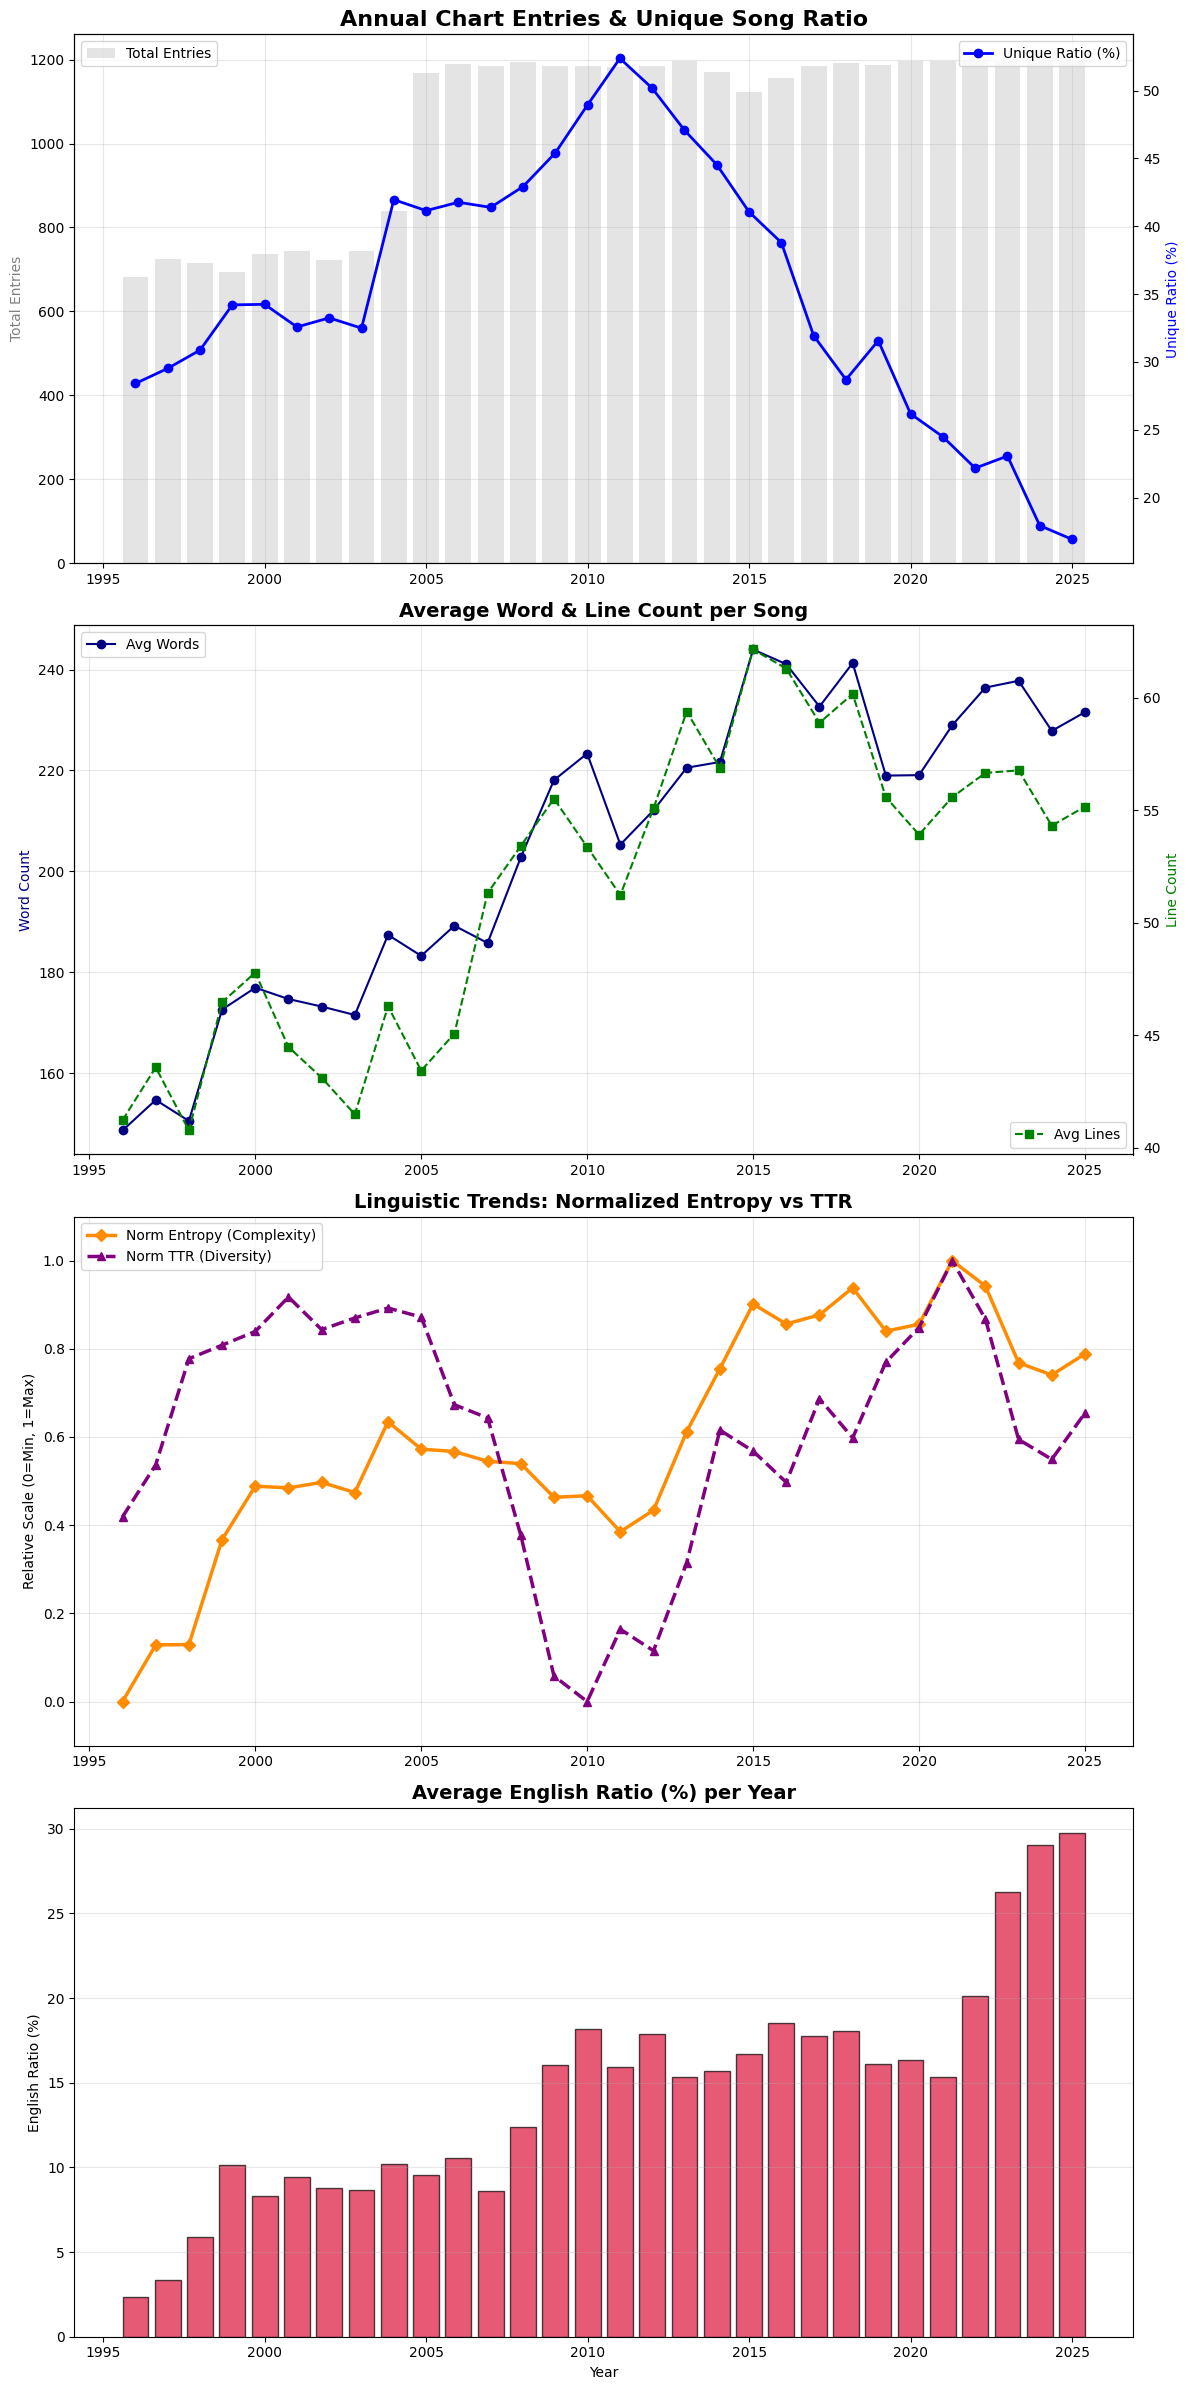

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import ast
from collections import Counter

# ------------------------------------------------------------------
# 1. 스타일 설정
# ------------------------------------------------------------------
plt.style.use('default')
plt.rcParams['axes.unicode_minus'] = False

def calculate_entropy(tokens):
    """ 섀넌 엔트로피 계산 """
    if not tokens: return 0
    total_len = len(tokens)
    counts = Counter(tokens)
    entropy = 0
    for count in counts.values():
        p = count / total_len
        entropy -= p * np.log2(p)
    return entropy

def analyze_phase2_hybrid_normalized_integrated():
    print("🚀 [Phase 2] 하이브리드 분석 + TTR/Entropy 정규화 통합 시작...")
    
    # 1. 파일 찾기
    all_files = sorted(glob.glob("Processed_Melon_Chart_*.xlsx") + glob.glob("Processed_Melon_Chart_*.csv") + glob.glob("*.csv"))
    target_files = [f for f in all_files if "Melon_Chart" in f]
    
    unique_files = {}
    for f in target_files:
        match = re.search(r'(\d{4})', f)
        if not match: continue
        year = int(match.group(1))
        if year not in unique_files: unique_files[year] = f
        elif f.endswith('.xlsx'): unique_files[year] = f

    results = []
    
    for year in sorted(unique_files.keys()):
        file_path = unique_files[year]
        try:
            if file_path.endswith('.csv'): df = pd.read_csv(file_path)
            else: df = pd.read_excel(file_path)
            
            if 'Processed_Tokens' not in df.columns: continue

            # (A) 전체 곡 수 & 고유 곡 수
            original_count = len(df)
            if 'Song_ID' in df.columns: df_unique = df.drop_duplicates(subset=['Song_ID']).copy()
            else: 
                cols = [c for c in ['Title', 'Artist'] if c in df.columns]
                if len(cols) == 2: df_unique = df.drop_duplicates(subset=cols).copy()
                else: df_unique = df.copy() 
            
            df_calc = df_unique.dropna(subset=['Lyrics', 'Processed_Tokens'])
            unique_count = len(df_unique)
            if original_count == 0: continue
            
            unique_ratio = (unique_count / original_count) * 100

            # (B) 지표 계산
            line_counts = []
            word_counts = []
            eng_ratios = []
            ttrs = []
            entropies = []

            for _, row in df_calc.iterrows():
                # 1. 원문 기반 (구조/영어)
                text = str(row['Lyrics'])
                clean_text = re.sub(r'\[.*?\]', '', text)
                raw_words = clean_text.split()
                lines = [l for l in text.split('\n') if l.strip()]
                
                total_raw_words = len(raw_words)
                word_counts.append(total_raw_words)
                line_counts.append(len(lines))
                
                if total_raw_words > 0:
                    eng_words = [w for w in raw_words if re.match(r'^[a-zA-Z]+$', w)]
                    eng_ratios.append((len(eng_words) / total_raw_words) * 100)
                else:
                    eng_ratios.append(0)

                # 2. 토큰 기반 (복잡도)
                tokens_str = row['Processed_Tokens']
                try:
                    if isinstance(tokens_str, str): tokens = ast.literal_eval(tokens_str)
                    else: tokens = tokens_str
                    if not tokens: tokens = raw_words 
                except: tokens = raw_words

                entropies.append(calculate_entropy(tokens))
                if len(tokens) > 0: ttrs.append(len(set(tokens)) / len(tokens))
                else: ttrs.append(0)

            results.append({
                'Year': year,
                'Original': original_count,
                'Unique': unique_count,
                'Unique_Ratio': unique_ratio,
                'Avg_Words': np.mean(word_counts),
                'Avg_Lines': np.mean(line_counts),
                'Avg_Eng_Ratio': np.mean(eng_ratios),
                'Avg_TTR': np.mean(ttrs),        
                'Avg_Entropy': np.mean(entropies) 
            })
            
        except Exception as e:
            print(f"❌ {year}년 에러: {e}")

    df_res = pd.DataFrame(results)

    # ==============================================================================
    # 2. 핵심: TTR & Entropy 정규화 (Min-Max Scaling)
    # ==============================================================================
    # 표와 그래프에 0~1 사이 값으로 변환해서 넣기 위함
    df_res['Norm_TTR'] = (df_res['Avg_TTR'] - df_res['Avg_TTR'].min()) / (df_res['Avg_TTR'].max() - df_res['Avg_TTR'].min())
    df_res['Norm_Entropy'] = (df_res['Avg_Entropy'] - df_res['Avg_Entropy'].min()) / (df_res['Avg_Entropy'].max() - df_res['Avg_Entropy'].min())

    # ==============================================================================
    # 3. 결과 테이블 출력 (정규화된 값 표시)
    # ==============================================================================
    print("\n📊 [Phase 2 종합 리포트 (TTR/Entropy 정규화 적용)]")
    print("=" * 130)
    # 헤더에 Norm 표시
    print(f"{'Year':<6} | {'Original':^8} | {'Unique (Ratio)':^20} | {'Words':^8} | {'Lines':^8} | {'Eng(%)':^8} | {'Norm_TTR':^8} | {'Norm_Ent':^8}")
    print("-" * 130)
    for _, row in df_res.iterrows():
        unique_str = f"{int(row['Unique'])} ({row['Unique_Ratio']:.1f}%)"
        # TTR과 Entropy를 정규화된 값(0.00~1.00)으로 출력
        print(f"{int(row['Year']):<6} | {int(row['Original']):^8} | {unique_str:^20} | {row['Avg_Words']:^8.1f} | {row['Avg_Lines']:^8.1f} | {row['Avg_Eng_Ratio']:^8.1f} | {row['Norm_TTR']:^8.3f} | {row['Norm_Entropy']:^8.3f}")
    print("=" * 130)

    # ==============================================================================
    # 4. 시각화 (4단 콤보 + 정규화 반영)
    # ==============================================================================
    if len(df_res) > 0:
        fig, axes = plt.subplots(4, 1, figsize=(12, 24))
        years = df_res['Year']

        # [Graph 1] 시장 현황
        ax1 = axes[0]
        ax1.bar(years, df_res['Original'], color='lightgray', label='Total Entries', alpha=0.6)
        ax1.set_ylabel('Total Entries', color='gray')
        ax2 = ax1.twinx()
        ax2.plot(years, df_res['Unique_Ratio'], color='blue', marker='o', linewidth=2, label='Unique Ratio (%)')
        ax2.set_ylabel('Unique Ratio (%)', color='blue')
        ax1.set_title('Annual Chart Entries & Unique Song Ratio', fontsize=16, fontweight='bold')
        ax1.legend(loc='upper left'); ax2.legend(loc='upper right'); ax1.grid(True, alpha=0.3)

        # [Graph 2] 양적 팽창
        ax3 = axes[1]
        ax3.plot(years, df_res['Avg_Words'], color='navy', marker='o', label='Avg Words')
        ax3.set_ylabel('Word Count', color='navy')
        ax4 = ax3.twinx()
        ax4.plot(years, df_res['Avg_Lines'], color='green', marker='s', linestyle='--', label='Avg Lines')
        ax4.set_ylabel('Line Count', color='green')
        ax3.set_title('Average Word & Line Count per Song', fontsize=14, fontweight='bold')
        ax3.legend(loc='upper left'); ax4.legend(loc='lower right'); ax3.grid(True, alpha=0.3)

        # [Graph 3] 🔥 언어적 복잡도 (정규화된 값 사용)
        ax5 = axes[2]
        # 둘 다 0~1 스케일이므로 같은 축(ax5)을 공유해서 그리면 비교가 더 잘됨!
        ax5.plot(years, df_res['Norm_Entropy'], color='darkorange', linewidth=2.5, marker='D', label='Norm Entropy (Complexity)')
        ax5.plot(years, df_res['Norm_TTR'], color='purple', linewidth=2.5, linestyle='--', marker='^', label='Norm TTR (Diversity)')
        
        ax5.set_ylabel('Relative Scale (0=Min, 1=Max)')
        ax5.set_ylim(-0.1, 1.1) # 0~1 범위 고정
        
        ax5.set_title('Linguistic Trends: Normalized Entropy vs TTR', fontsize=14, fontweight='bold')
        ax5.legend(loc='upper left')
        ax5.grid(True, alpha=0.3)

        # [Graph 4] 글로벌화
        ax7 = axes[3]
        ax7.bar(years, df_res['Avg_Eng_Ratio'], color='crimson', alpha=0.7, edgecolor='black')
        ax7.set_ylabel('English Ratio (%)')
        ax7.set_xlabel('Year')
        ax7.set_title('Average English Ratio (%) per Year', fontsize=14, fontweight='bold')
        ax7.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('Phase2_Final_Integrated_Norm.png', dpi=300)
        print("\n📈 최종 통합 그래프(정규화 포함) 저장 완료: Phase2_Final_Integrated_Norm.png")
        
        df_res.to_csv("Phase2_Final_Data_Integrated_Norm.csv", index=False)
        print("💾 최종 데이터 파일 저장 완료.")

if __name__ == "__main__":
    analyze_phase2_hybrid_normalized_integrated()

# 워드클라우드

🚀 [Phase 3] Grand Finale: 시각화 생성 시작...
✅ 워드클라우드 저장 완료: Phase3_Final_WordCloud.png
✅ 트렌드 그래프 저장 완료: Phase3_Final_Evolution_Graph.png

🎉 모든 분석이 끝났습니다! 저장된 2개의 이미지를 확인하세요.


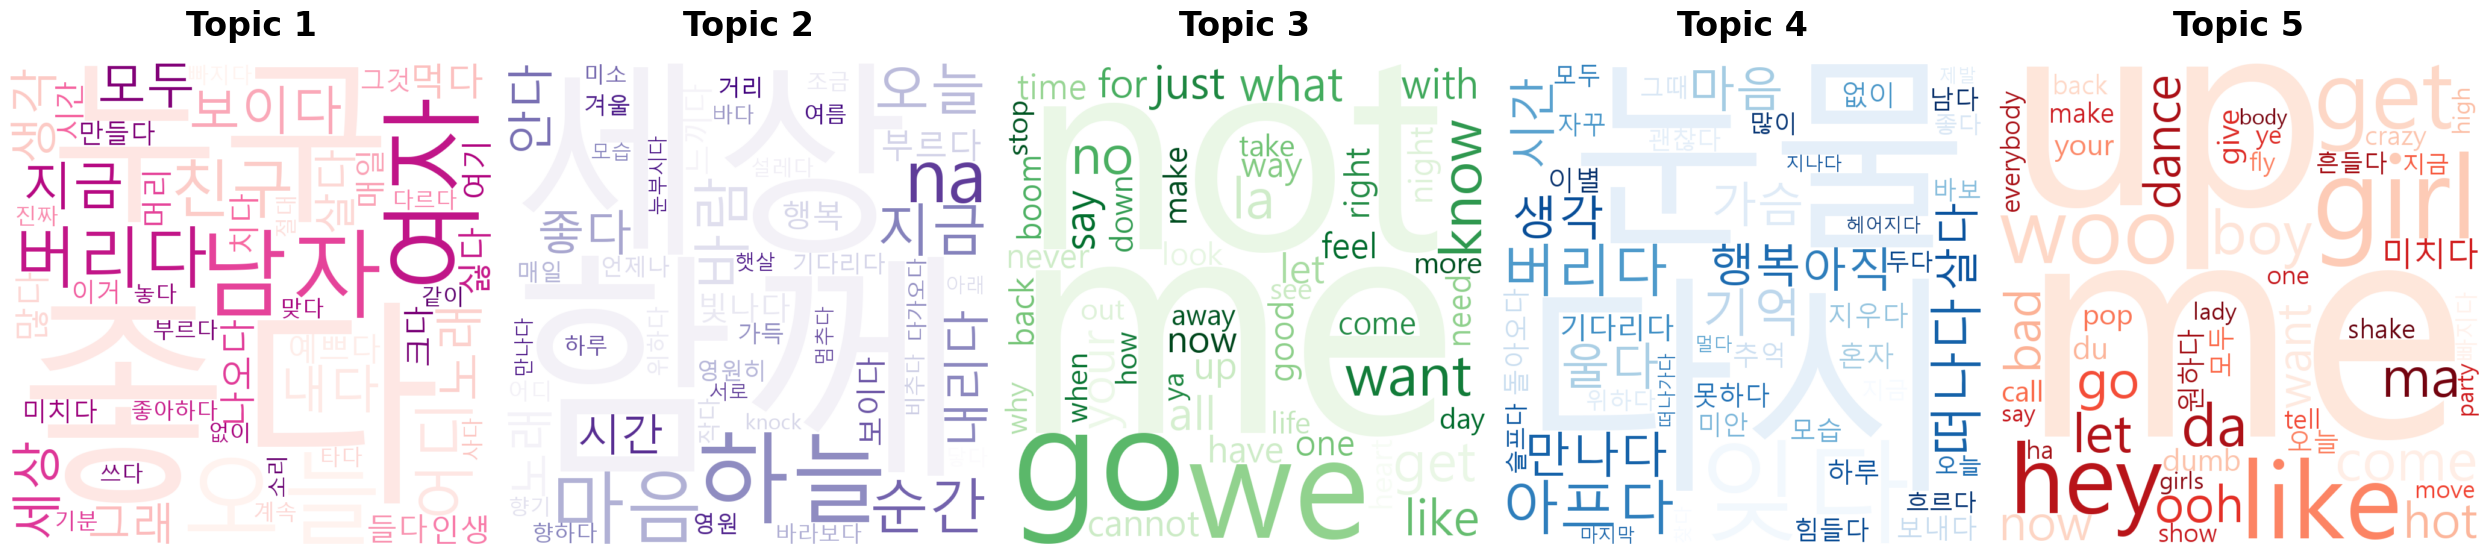

<Figure size 1400x800 with 0 Axes>

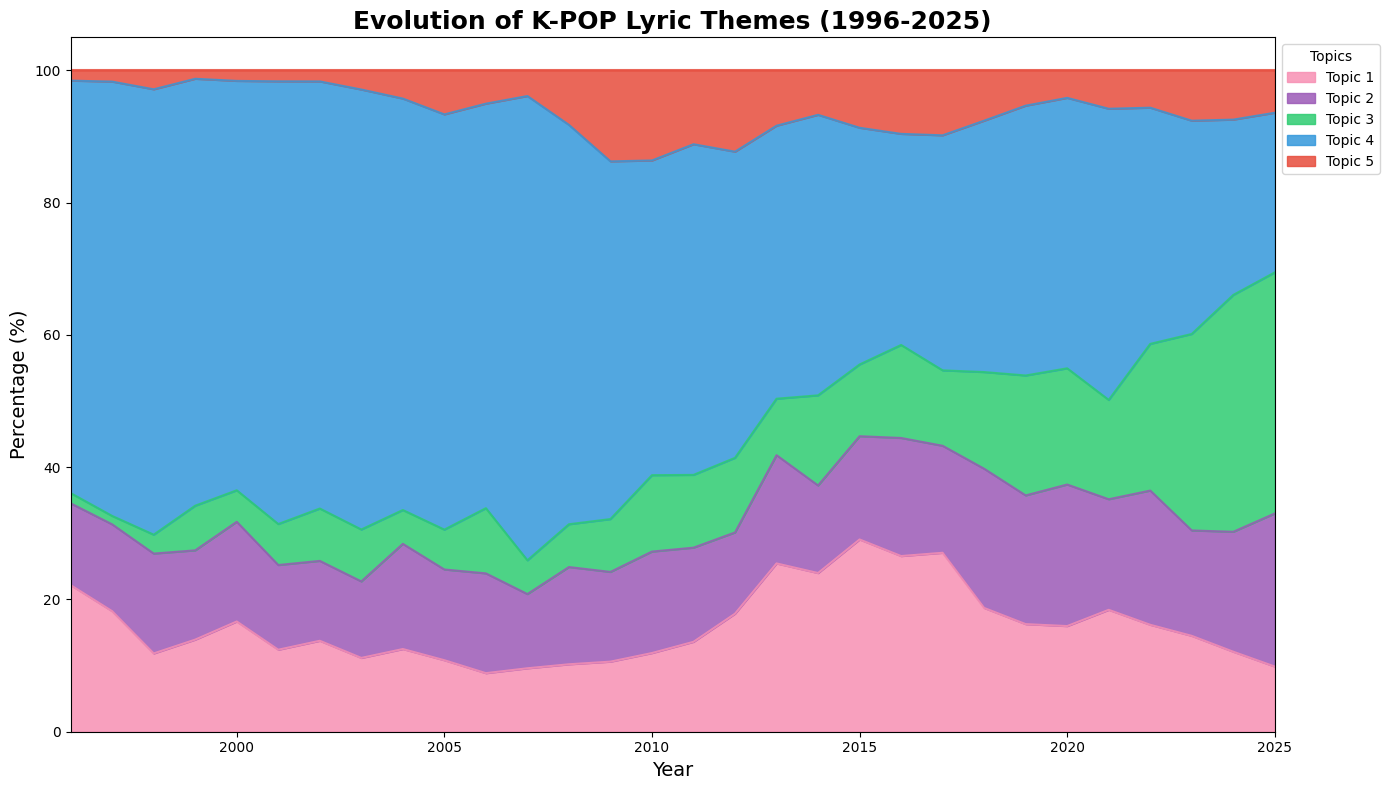

In [31]:
import pandas as pd
import glob
import re
import ast
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ==============================================================================
# 1. 환경 설정
# ==============================================================================
plt.style.use('default')
plt.rcParams['axes.unicode_minus'] = False
# 폰트 경로 (환경에 맞게 수정)
FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' 

# 방금 확정한 불용어 리스트
STOPWORDS = {
    '나', '너', '내', '네', '널', '날', '난', '넌', '우리', '그대', '그', '그녀',
    '수', '것', '곳', '때', '건', '게', '걸', '위', '속', '듯', '좀', '중',
    '이', '그', '저', '안', '밖', '옆', '앞', '뒤',
    '하다', '되다', '같다', '보다', '싶다', '않다', '가다', '오다', '있다', '없다',
    '사람', '사랑', 
    '말다', '알다', '나다', '모르다', '너무', '정말', '그냥', # 노이즈 추가 제거
    'oh', 'yeah', 'baby', 'im', 'you', 'love'
}

def run_phase3_grand_finale():
    print("🚀 [Phase 3] Grand Finale: 시각화 생성 시작...")
    
    # 1. 데이터 로드
    all_files = sorted(glob.glob("Processed_Melon_Chart_*.xlsx") + glob.glob("Processed_Melon_Chart_*.csv") + glob.glob("*.csv"))
    target_files = [f for f in all_files if "Melon_Chart" in f]
    
    docs = []
    years = []
    
    for f in target_files:
        try:
            match = re.search(r'(\d{4})', f)
            if not match: continue
            year = int(match.group(1))

            if f.endswith('.csv'): df = pd.read_csv(f)
            else: df = pd.read_excel(f)
            
            target_col = 'Processed_Tokens'
            if target_col not in df.columns: continue

            if 'Lyrics' in df.columns: df = df.drop_duplicates(subset=['Lyrics'])
            df = df.dropna(subset=[target_col])

            for tokens_str in df[target_col]:
                try:
                    if isinstance(tokens_str, str): tokens = ast.literal_eval(tokens_str)
                    else: tokens = tokens_str
                    
                    clean_tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 1]
                    if len(clean_tokens) >= 5:
                        docs.append(clean_tokens)
                        years.append(year)
                except: continue
        except: continue

    # 2. LDA 모델링
    dictionary = corpora.Dictionary(docs)
    dictionary.filter_extremes(no_below=10, no_above=0.4)
    corpus = [dictionary.doc2bow(text) for text in docs]
    
    lda_model = models.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=5, passes=20, random_state=42
    )

    # ==========================================================================
    # 3. [시각화 1] 워드클라우드 (토픽별)
    # ==========================================================================
    fig1, axes = plt.subplots(1, 5, figsize=(25, 6))
    # 색상 테마: T1(일상/분홍), T2(영어팝/보라), T3(희망/초록), T4(이별/파랑), T5(댄스/빨강)
    colormaps = ['RdPu', 'Purples', 'Greens', 'Blues', 'Reds']
    
    # 토픽 순서가 실행마다 바뀔 수 있으니 키워드를 보고 매칭해야 하지만, 
    # 여기서는 순서대로 출력합니다. (결과 확인 후 매칭 필요)
    for i in range(5):
        topic_words = dict(lda_model.show_topic(i, topn=50))
        wc = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=800, colormap=colormaps[i], random_state=42)
        wc.generate_from_frequencies(topic_words)
        
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f"Topic {i+1}", fontsize=24, fontweight='bold', pad=20)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('Phase3_Final_WordCloud.png', dpi=300)
    print("✅ 워드클라우드 저장 완료: Phase3_Final_WordCloud.png")

    # ==========================================================================
    # 4. [시각화 2] 연도별 트렌드 (Stacked Area Chart)
    # ==========================================================================
    topic_counts = {y: [0]*5 for y in sorted(list(set(years)))}
    
    for i, doc_bow in enumerate(corpus):
        year = years[i]
        topic_dist = lda_model.get_document_topics(doc_bow)
        if topic_dist:
            dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
            topic_counts[year][dominant_topic] += 1

    df_trend = pd.DataFrame.from_dict(topic_counts, orient='index', columns=[f'Topic {i+1}' for i in range(5)])
    df_ratio = df_trend.div(df_trend.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(14, 8))
    # 위 워드클라우드와 매칭되는 색상 코드
    # T1(분홍), T2(보라), T3(초록), T4(파랑), T5(빨강)
    colors = ['#F78FB3', '#9B59B6', '#2ECC71', '#3498DB', '#E74C3C']
    
    df_ratio.plot(kind='area', stacked=True, color=colors, alpha=0.85, figsize=(14, 8))
    
    plt.title('Evolution of K-POP Lyric Themes (1996-2025)', fontsize=18, fontweight='bold')
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title="Topics")
    plt.margins(x=0)
    plt.tight_layout()
    
    plt.savefig('Phase3_Final_Evolution_Graph.png', dpi=300)
    print("✅ 트렌드 그래프 저장 완료: Phase3_Final_Evolution_Graph.png")
    
    print("\n🎉 모든 분석이 끝났습니다! 저장된 2개의 이미지를 확인하세요.")

if __name__ == "__main__":
    run_phase3_grand_finale()

# 클러스터링

🚀 [System] 연도별 가사 클러스터링 시작...
✅ 벡터화 완료: (30, 1000) (연도 x 단어수)
✅ 덴드로그램 저장 완료: Era_Dendrogram.png
✅ PCA 맵 저장 완료: Era_PCA_Map.png


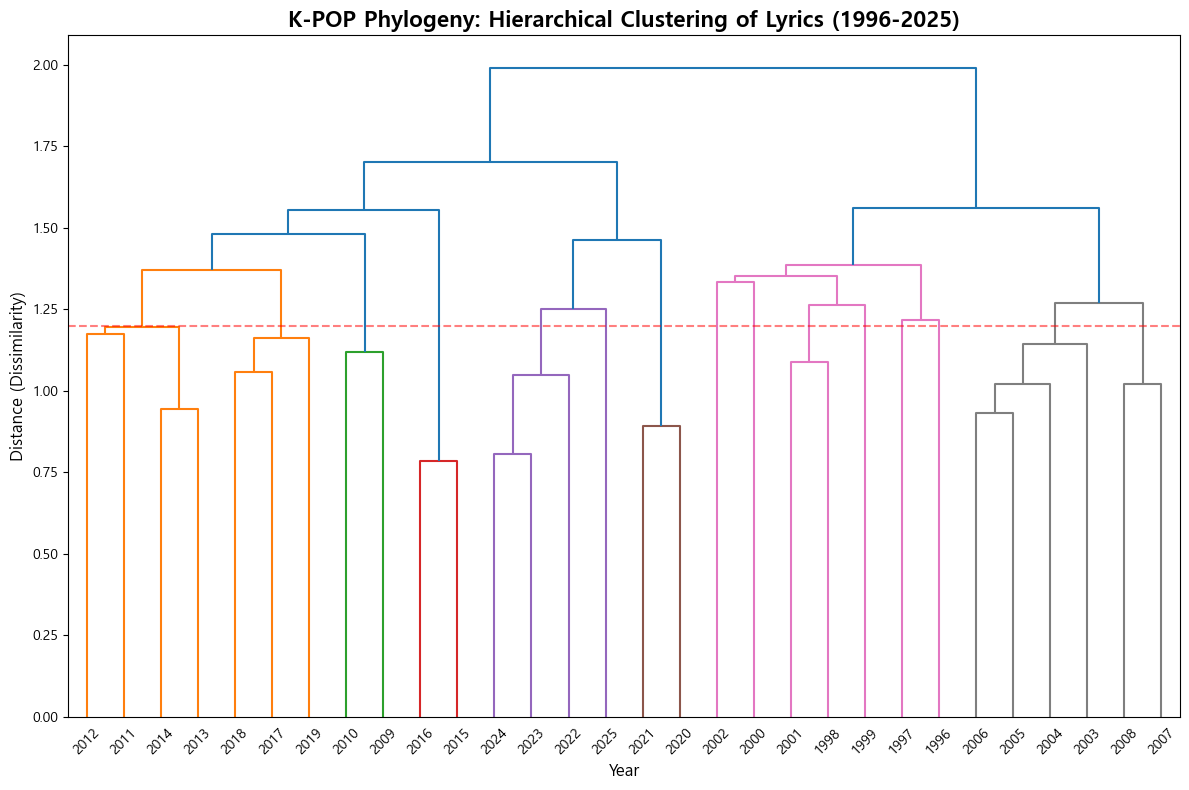

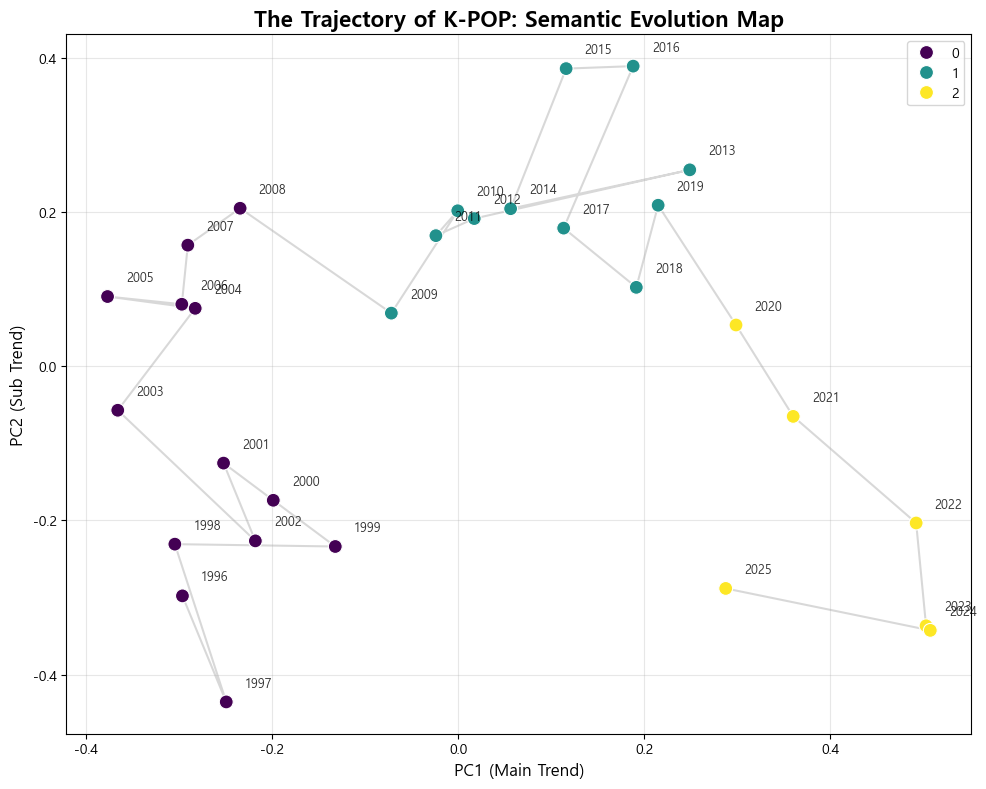

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import ast
import platform
from matplotlib import font_manager, rc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. 폰트 설정
def set_korean_font():
    if platform.system() == 'Windows':
        font_path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Darwin':
        rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# 2. 데이터 로드 및 연도별 통합
def analyze_era_clustering():
    print("🚀 [System] 연도별 가사 클러스터링 시작...")
    
    all_files = sorted(glob.glob("Processed_Melon_Chart_*.xlsx") + glob.glob("Processed_Melon_Chart_*.csv") + glob.glob("*.csv"))
    target_files = [f for f in all_files if "Melon_Chart" in f]
    
    # 연도별로 가사 텍스트를 하나로 합침 (Document per Year)
    yearly_lyrics = {} 
    
    for f in target_files:
        try:
            if f.endswith('.csv'): df = pd.read_csv(f)
            else: df = pd.read_excel(f)
            
            # 연도 추출
            match = re.search(r'(\d{4})', f)
            if match: 
                year = int(match.group(1))
            else: continue
            
            # 가사 컬럼 찾기 (형태소 분석된 토큰 리스트 추천)
            target_col = None
            for col in ['Processed_Tokens', 'Morphemes', 'Lyrics_List']:
                if col in df.columns:
                    target_col = col
                    break
            
            if not target_col: continue

            # 해당 연도의 모든 단어를 하나의 문자열로 합침
            all_tokens = []
            for val in df[target_col]:
                if isinstance(val, str):
                    # 리스트 문자열인 경우 파싱
                    try: 
                        tokens = ast.literal_eval(val)
                        if isinstance(tokens, list): all_tokens.extend(tokens)
                        else: all_tokens.extend(val.split())
                    except: 
                        all_tokens.extend(val.split())
                elif isinstance(val, list):
                    all_tokens.extend(val)
            
            # 불용어 좀 더 빡세게 제거 (너무 흔한 단어는 시대 구분에 방해됨)
            STOPWORDS = set(['나', '너', '우리', '그대', '사랑', '사람', '마음', '생각', '모습', '오늘', '다시', '이제', '정말', '수', '것', '내', '난', '널', '좀', '걸', '건', '게', '날', '때', '말', '하다', '있다', '없다'])
            filtered_tokens = [t for t in all_tokens if t not in STOPWORDS and len(t) > 1]
            
            yearly_lyrics[year] = " ".join(filtered_tokens)

        except: pass

    # 데이터프레임 변환 (Index: Year, Column: Lyrics)
    df_years = pd.DataFrame(list(yearly_lyrics.items()), columns=['Year', 'Lyrics']).sort_values('Year')
    
    if df_years.empty:
        print("❌ 데이터가 없습니다.")
        return

    # 3. TF-IDF 벡터화 (단어의 시대적 가중치 계산)
    # min_df=2: 최소 2개 연도에는 등장해야 함
    # max_df=0.9: 90% 이상의 연도에 다 나오는 흔한 단어(사랑 등) 제외 -> 중요!
    tfidf = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.9)
    X = tfidf.fit_transform(df_years['Lyrics']).toarray()
    
    print(f"✅ 벡터화 완료: {X.shape} (연도 x 단어수)")

    # 4. 계층적 클러스터링 (Hierarchical Clustering)
    # ward 방식: 군집 간 분산을 최소화하며 합침
    linked = linkage(X, 'ward')

    # 시각화 1: 덴드로그램 (Dendrogram) - 시대의 계보도
    plt.figure(figsize=(12, 8))
    dendrogram(linked,
               orientation='top',
               labels=df_years['Year'].astype(str).values,
               distance_sort='descending',
               show_leaf_counts=True)
    
    plt.title("K-POP Phylogeny: Hierarchical Clustering of Lyrics (1996-2025)", fontsize=16, fontweight='bold')
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Distance (Dissimilarity)", fontsize=12)
    plt.axhline(y=1.2, c='r', ls='--', alpha=0.5) # 컷오프 예시 라인
    
    plt.tight_layout()
    plt.savefig("Era_Dendrogram.png", dpi=300)
    print("✅ 덴드로그램 저장 완료: Era_Dendrogram.png")
    
    # 5. 시각화 2: PCA 산점도 (시대의 이동 경로)
    # 2차원으로 차원 축소하여 연도별 위치를 찍어봄
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    
    # 클러스터링 (예: 3개 시대로 구분한다고 가정)
    cluster_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
    labels = cluster_model.fit_predict(X)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, palette='viridis', s=100, zorder=2)
    
    # 연도 텍스트 표시
    for i, year in enumerate(df_years['Year']):
        plt.text(coords[i,0]+0.02, coords[i,1]+0.02, str(year), fontsize=9, alpha=0.8)
        
    # 이동 경로 선 그리기 (Trajectory)
    plt.plot(coords[:,0], coords[:,1], color='gray', alpha=0.3, zorder=1)
    
    plt.title("The Trajectory of K-POP: Semantic Evolution Map", fontsize=16, fontweight='bold')
    plt.xlabel("PC1 (Main Trend)", fontsize=12)
    plt.ylabel("PC2 (Sub Trend)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("Era_PCA_Map.png", dpi=300)
    print("✅ PCA 맵 저장 완료: Era_PCA_Map.png")

    plt.show()

if __name__ == "__main__":
    analyze_era_clustering()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import ast
from collections import Counter

# ------------------------------------------------------------------
# 1. 데이터 추출 & 계산
# ------------------------------------------------------------------
def calculate_metrics(tokens):
    if not tokens or len(tokens) == 0: return 0, 0
    ttr = len(set(tokens)) / len(tokens)
    counts = Counter(tokens)
    probs = [cnt / len(tokens) for cnt in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs)
    return ttr, entropy

def analyze_full_era_quadrant():
    print("🚀 [System] 30년 전체 데이터 4분면 매핑 시작...")
    
    all_files = sorted(glob.glob("Processed_Melon_Chart_*.xlsx") + glob.glob("Processed_Melon_Chart_*.csv") + glob.glob("*.csv"))
    target_files = [f for f in all_files if "Melon_Chart" in f]
    
    results = []

    for f in target_files:
        try:
            match = re.search(r'(\d{4})', f)
            if not match: continue
            year = int(match.group(1))
            
            if f.endswith('.csv'): df = pd.read_csv(f)
            else: df = pd.read_excel(f)
            
            # 컬럼 찾기
            target_col = None
            for col in ['Processed_Tokens', 'Morphemes', 'Lyrics_List', 'Lyrics']:
                if col in df.columns:
                    target_col = col
                    break
            if not target_col: continue

            for val in df[target_col]:
                tokens = []
                if isinstance(val, list): tokens = val
                elif isinstance(val, str):
                    try: tokens = ast.literal_eval(val)
                    except: tokens = val.split()
                
                if tokens:
                    t, e = calculate_metrics(tokens)
                    results.append({
                        'Year': year,
                        'TTR': t,
                        'Entropy': e
                    })
        except: pass

    df = pd.DataFrame(results)

    # 정규화 (전체 곡 대상)
    df['Norm_TTR'] = (df['TTR'] - df['TTR'].min()) / (df['TTR'].max() - df['TTR'].min())
    df['Norm_Entropy'] = (df['Entropy'] - df['Entropy'].min()) / (df['Entropy'].max() - df['Entropy'].min())

    # ------------------------------------------------------------------
    # 시각화 1: 30년 전체 4분면 지도 (The Great Migration)
    # ------------------------------------------------------------------
    plt.figure(figsize=(14, 12))
    sns.set_style("whitegrid")
    
    # 산점도 (Scatter Plot)
    # c=df['Year']: 연도에 따라 색상 부여
    # cmap='viridis': 보라(과거) -> 노랑(최근)
    scatter = plt.scatter(x=df['Norm_Entropy'], y=df['Norm_TTR'], 
                          c=df['Year'], cmap='viridis', 
                          s=40, alpha=0.5, edgecolors='none')
    
    # 4분면 기준선
    plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
    
    # 컬러바 (연도 표시)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Year (Purple: 90s -> Yellow: 2020s)', rotation=270, labelpad=20, fontsize=12)
    
    # 라벨링
    plt.text(0.95, 0.95, 'Type A: Complex & Diverse\n(High-Level Lyrics)', ha='right', va='top', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    plt.text(0.05, 0.05, 'Type C: Simple & Repetitive\n(Hook Songs)', ha='left', va='bottom', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    plt.text(0.95, 0.05, 'Type D: Complex Context\nbut Repetitive Words', ha='right', va='bottom', fontsize=10, color='gray')
    plt.text(0.05, 0.95, 'Type B: Simple Context\nbut Diverse Words', ha='left', va='top', fontsize=10, color='gray')

    plt.title("The Evolution of K-POP Lyrics (1996-2025): A Quadrant Map", fontsize=18, fontweight='bold')
    plt.xlabel("Normalized Entropy (Complexity) →", fontsize=14)
    plt.ylabel("Normalized TTR (Diversity) →", fontsize=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig("Full_Era_Quadrant_Map.png", dpi=300)
    print("✅ 30년 전체 4분면 지도 저장 완료: Full_Era_Quadrant_Map.png")
    
if __name__ == "__main__":
    analyze_full_era_quadrant()